<a href="https://colab.research.google.com/github/yukuproj/homework1/blob/main/sobes_notebook_pd_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔮 Ad-Exchange Auction Prediction Problem


----
-----


---
----


 Problem Understanding

The task is to predict the probability of winning a bid in an ad-exchange auction, where the highest bid wins. This involves analyzing various features of the auction environment, such as bid prices, device types, and auction platforms, to build a machine learning model capable of accurately forecasting the auction outcomes. The model's performance will be evaluated using the F1 score, with the goal of exceeding the provided baseline score of 0.503.







### Solution steps:

The process involves the following steps:

1. **Google Drive Setup**: Mount Google Drive and load the datasets from the specified location.

2. **Loading the Utility Module**: The auxiliary functions and procedures are encapsulated in the `factor_utils.py` module. This module is loaded before proceeding with data analysis.

3. **One-Factor Analysis**: Conduct a descriptive analysis for each feature, identifying and visualizing the relationships between them and the target variable.

4. **Model Construction and Performance Comparison**:
   - Construct several models (Artificial Neural Networks (ANN), XGBoost, Decision Trees, Logistic Regression).
   - Compare the models using performance metrics such as F1-score and Gini or ROC AUC coefficient.

5. **Dataset Loading**: The dataset is loaded from a compressed file using `pandas.read_csv()`.

6. **Descriptive Analysis**: For each feature, the statistical properties and correlations with the target variable are explored.

7. **Feature Engineering**:
   - Numeric features undergo transformations such as logistic transformation to handle extreme values.
   - Categorical features are processed through grouping and Weight of Evidence (WOE) encoding to convert them into numeric representations.

8. **Outlier Detection and Removal**: Detect outliers and remove them from the dataset to improve model performance.

9. **Data Preprocessing**: Missing data is handled, redundant features are removed, and categorical variables are converted into dummy variables. This prepares the dataset for training machine learning models.

10. **Train-Test Split**: The dataset is split into training and testing sets to evaluate the performance of the models on unseen data.

11. **Data Normalization**: Features are normalized to ensure that models are trained on standardized data.

12. **Model Building**:
    - **ANN**: A simple feed-forward neural network is constructed, trained, and evaluated using the F1-score and Gini coefficient.
    - **XGBoost**: A gradient-boosting classifier is tuned through cross-validation and hyperparameter optimization. Performance is compared against the ANN model.
    - **Random Forest**: A Random Forest classifier is trained using hyperparameter tuning. It is evaluated using the same metrics.
    - **Logistic Regression**: A logistic regression model is built, evaluated, and compared to the previous models.

13. **Optimal Cutoff Calculation**: The optimal cutoff for classification is determined based on preserving the same mean probability of Bid.

14. **Visualization and Evaluation**:
   - Correlation heatmaps, ROC curves, and confusion matrices are plotted for each model to visualize their performance.
   - The models' Gini coefficients and F1-scores are compared for both training and testing sets.



This process leads to a comprehensive analysis and comparison of machine learning models for predicting the target variable, focusing on maximizing the performance metrics.



MAIN RESULT: models perfomance comparison (copied from the very end of this notebook!!!)

Red vertical lines here are the baseline levels

As the graphs indicate, all models outperformed the baseline in both the Gini coefficient and F1 score, except for the ANN model, which showed suboptimal performance on the F1 score but excelled in terms of the Gini coefficient. This is because the ANN was trained with optimization focused on the Gini coefficient.

## **SOLUTION:**

In [123]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import zipfile
import pandas as pd
import sys

sys.path.append('/content/drive/MyDrive/data')
sys.path.append('/content/drive/MyDrive/python')
# read the dataset using the compression zip
data = pd.read_csv('/content/drive/MyDrive/data/train_data.zip',compression='zip')

In [3]:
import factor_utils # custom libary
from importlib import reload # reload
reload(factor_utils)

<module 'factor_utils' from '/content/drive/MyDrive/python/factor_utils.py'>

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install hvplot

In [6]:
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [7]:
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [8]:
#data = pd.read_csv("train_data.csv")
data_test = pd.read_csv("/content/drive/MyDrive/data/test_data.csv")

In [9]:
data_test.columns

Index(['target', 'flr', 'sellerClearPrice', 'hour', 'ssp', 'dsp',
       'auctionBidFloorSource', 'sdk', 'sdkver', 'bundle', 'os', 'lang',
       'country', 'region', 'request_context_device_w',
       'request_context_device_h', 'bidderFlrPolicy', 'adt', 'dc', 'contype',
       'request_context_device_type', 'ifa', 'price'],
      dtype='object')

In [10]:
data.describe(include = "all")

,target,flr,sellerClearPrice,hour,ssp,dsp,auctionBidFloorSource,sdk,sdkver,bundle,os,lang,country,region,request_context_device_w,request_context_device_h,bidderFlrPolicy,adt,dc,contype,request_context_device_type,ifa,price
count,9640735.00,9640735.00,9640735.00,9640735.00,9640735.00,9640735.00,9640735,9640733,9640733,9640735,9640734,9640734,9640734,9292023,9640734.00,9640734.00,9640734,9640734,9640734,9640734.00,9640734.00,5279641,9640734.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,5,1,14,5,2,1303,121,565,NaN,NaN,3,1,1,NaN,NaN,990006,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,ml,BidMachine,2.4.0.2,gAAAAABmcEFTEPcMMU786QLAISLs22JucTR9XWAoRq7NAM...,ios,en,US,tx,NaN,NaN,original,interstitial,US,NaN,NaN,31b780ad-8418-4252-af67-3683b8b6ceda,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,4335419,9640733,5277994,5585485,5596411,5879832,4995857,468045,NaN,NaN,5703725,9640734,9640734,NaN,NaN,328,NaN
mean,0.08,2.97,3.31,11.56,157.00,81.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,693.22,1365.05,NaN,NaN,NaN,2.48,4.21,NaN,4.42
std,0.28,4.07,4.43,7.68,0.00,24.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289.04,591.37,NaN,NaN,NaN,1.18,0.41,NaN,5.96
min,0.00,0.01,0.01,0.00,157.00,23.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.00,2.00,NaN,NaN,NaN,0.00,1.00,NaN,0.01
25%,0.00,0.69,0.83,4.00,157.00,76.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,393.00,852.00,NaN,NaN,NaN,2.00,4.00,NaN,1.13
50%,0.00,1.49,1.78,12.00,157.00,80.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.00,1080.00,NaN,NaN,NaN,2.00,4.00,NaN,2.42
75%,0.00,4.65,4.41,19.00,157.00,80.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,900.00,1800.00,NaN,NaN,NaN,2.00,4.00,NaN,5.80


# 🔍 Exploratory Data Analysis

> **OVERALL GOAL:**
> - Get an understanding for which variables are important, view summary statistics, and visualize the data

For each feature, we can determine the type of the variable (continuous or categorical) and assess whether it should be included in the preliminary list of features to be used for model construction.

continuous variables are marked with **bold**

* target - (0,1) - Target variable (indicating bid win or loss)
*  **flr** - (0.01 .. 449.55) - Continuous variable
* **sellerClearPrice** - (0.01 .. 371.45) - Continuous variable
* hour - (0 .. 23) - Time variable (can be transformed into a categorical variable or used to create sine and cosine features to capture the cyclical nature of time)
* ssp - Only one value (157) - Exclude this feature
* dsp - (23 .. 236) - Categorical variable
* auctionBidFloorSource - (lurl, ml_original, rollouts, user_ml) - Categorical variable
* sdk - Only one value (Bidmachine) - Exclude this feature
* sdkver - (1.9.10 .. 2.5.0) - Categorical variable
* bundle - (#5 different values) - Categorical variable
* os - (android, ios) - Categorical variable
* lang - (#1303 different values) - Categorical variable
* country - (#121 values) - Categorical variable
* region - (#565 values) - Categorical variable
* **request_context_device_w** - Continuous variable
* **request_context_device_h** - Continuous variable
* bidderFlrPolicy - (#3 values) - Categorical variable
* adt - Only one value - Exclude this feature
* dc - Only one value - Exclude this feature
* contype - (0 .. 7) - Categorical variable
* request_context_device_type - (1, 4, 5) - Categorical variable
* ifa - (#990,006 values) - Too many unique IDs, unnecessary for this task
* **price** - Continuous variable

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9640735 entries, 0 to 9640734
Data columns (total 23 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   target                       int64  
 1   flr                          float64
 2   sellerClearPrice             float64
 3   hour                         int64  
 4   ssp                          int64  
 5   dsp                          int64  
 6   auctionBidFloorSource        object 
 7   sdk                          object 
 8   sdkver                       object 
 9   bundle                       object 
 10  os                           object 
 11  lang                         object 
 12  country                      object 
 13  region                       object 
 14  request_context_device_w     float64
 15  request_context_device_h     float64
 16  bidderFlrPolicy              object 
 17  adt                          object 
 18  dc                           object 
 19  

In [12]:
numeric_features = ['flr', 'sellerClearPrice', 'request_context_device_w', 'request_context_device_h', 'price']
time_feature = 'hour'
categoric_features = ['ssp', 'dsp', 'auctionBidFloorSource', 'sdk', 'sdkver', 'bundle', 'os', 'lang',
                      'country', 'region', 'bidderFlrPolicy', 'adt', 'dc', 'contype', 'request_context_device_type', 'ifa']
target_feature = 'target'
print(len(numeric_features)  + len(time_feature) + len(categoric_features) )

25


In [13]:
for name in data.columns:
    if (name not in categoric_features):
        if (name not in numeric_features):
            if (name  not in time_feature):
                    print("missing feature:" + name)

missing feature:target


## 🎯 ✔️ `Target`

In [14]:
target_mean = data.target.mean()
print(target_mean)
#0.0831950053600685 on the whole dataset

0.0831950053600685


## Sampling for Analysis

We can sample from the entire dataset for analysis and model building. As demonstrated by multiple runs of this notebook, there is not much difference in the results when conducting analysis on a sample of 50,000 observations. However, we can still evaluate our model on the entire test set.

In [15]:
data = data.sample(n=50000) #randomly sample from the whole population

## ✔️ One factor analysis  ( `numeric_features`)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 0.009999998
max = 134.66925
after cutting: min =0.0106
after cutting: max =9.48905744999998
Start plotting...
 min x for ROC 0.0106 max x for ROC 9.48905744999998
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


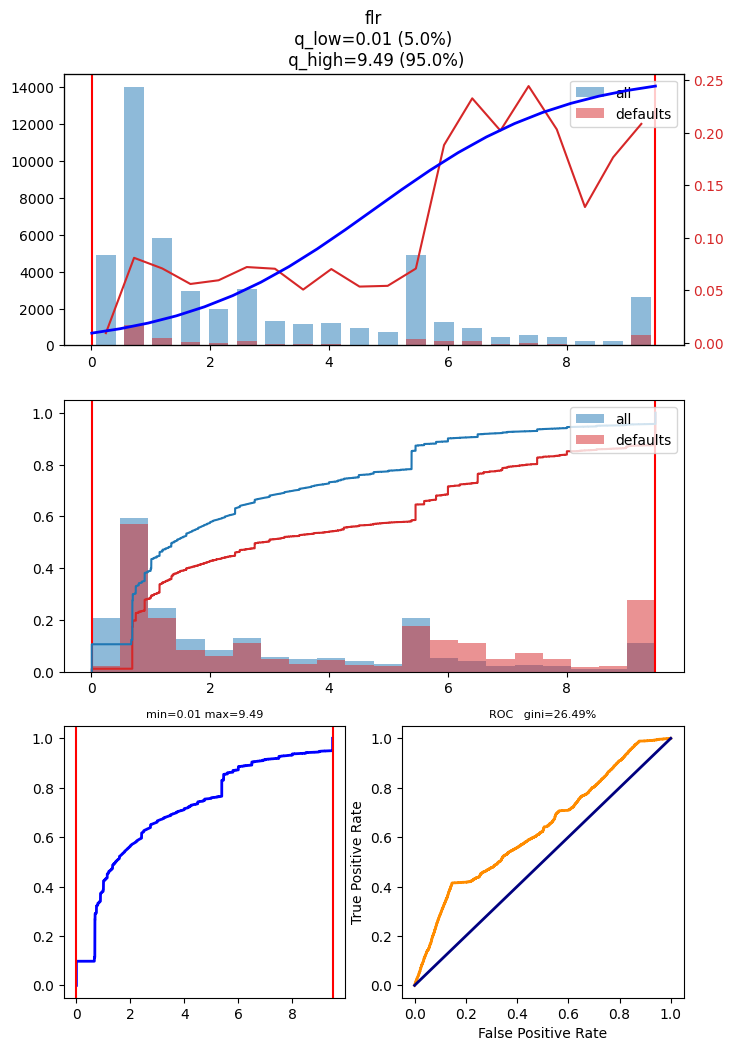

In [16]:
make_graphs_for_features = True

f_name = "flr"

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 0.010839
max = 165.94032
after cutting: min =0.500577
after cutting: max =10.41237254999998
Start plotting...
 min x for ROC 0.500577 max x for ROC 10.41237254999998
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


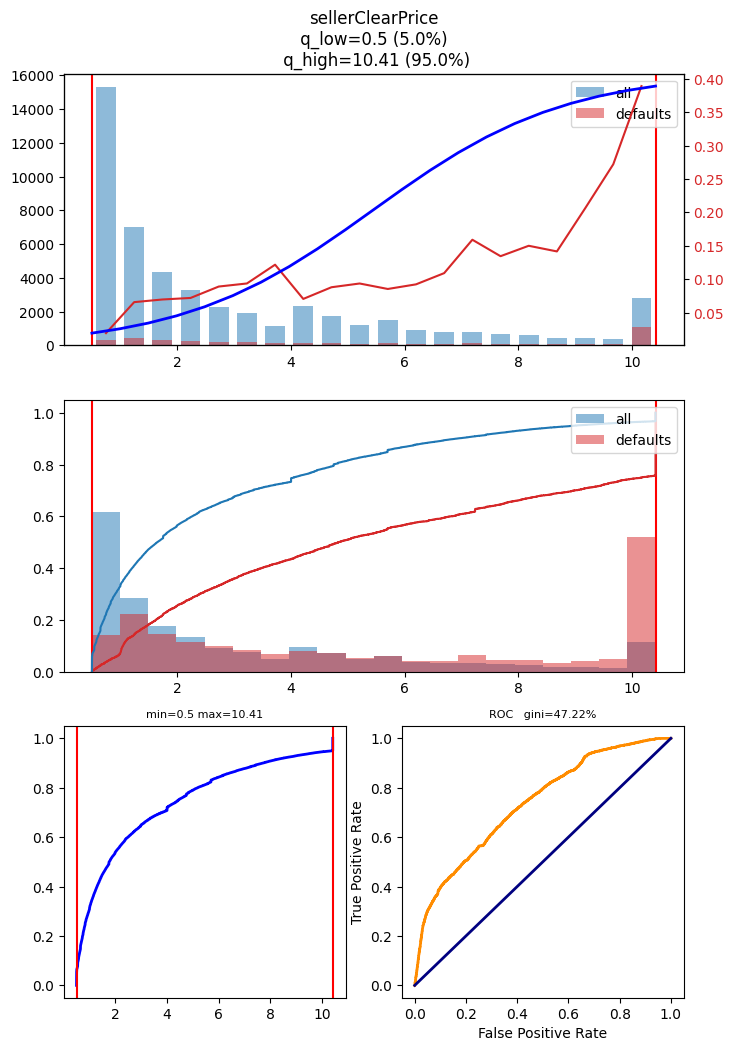

In [17]:
f_name = "sellerClearPrice"

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 320.0
max = 2268.0
after cutting: min =375.0
after cutting: max =1080.0
Start plotting...
 min x for ROC 375.0 max x for ROC 1080.0
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


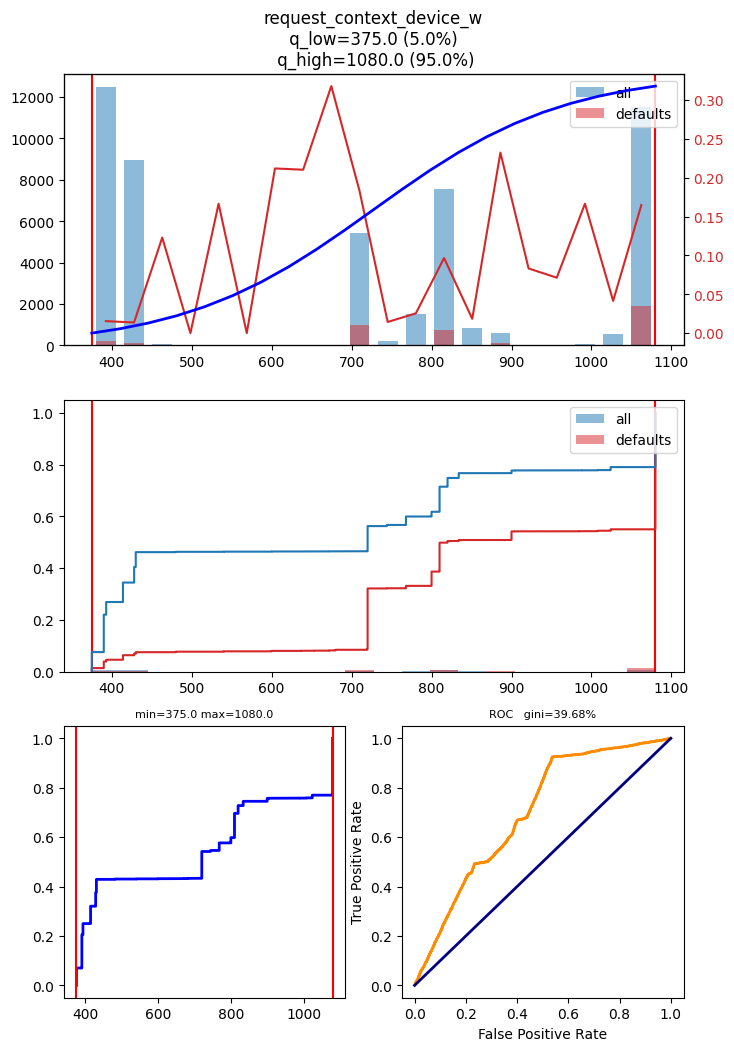

In [18]:
f_name = 'request_context_device_w'

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 512.0
max = 3216.0
after cutting: min =812.0
after cutting: max =2400.0
Start plotting...
 min x for ROC 812.0 max x for ROC 2400.0
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


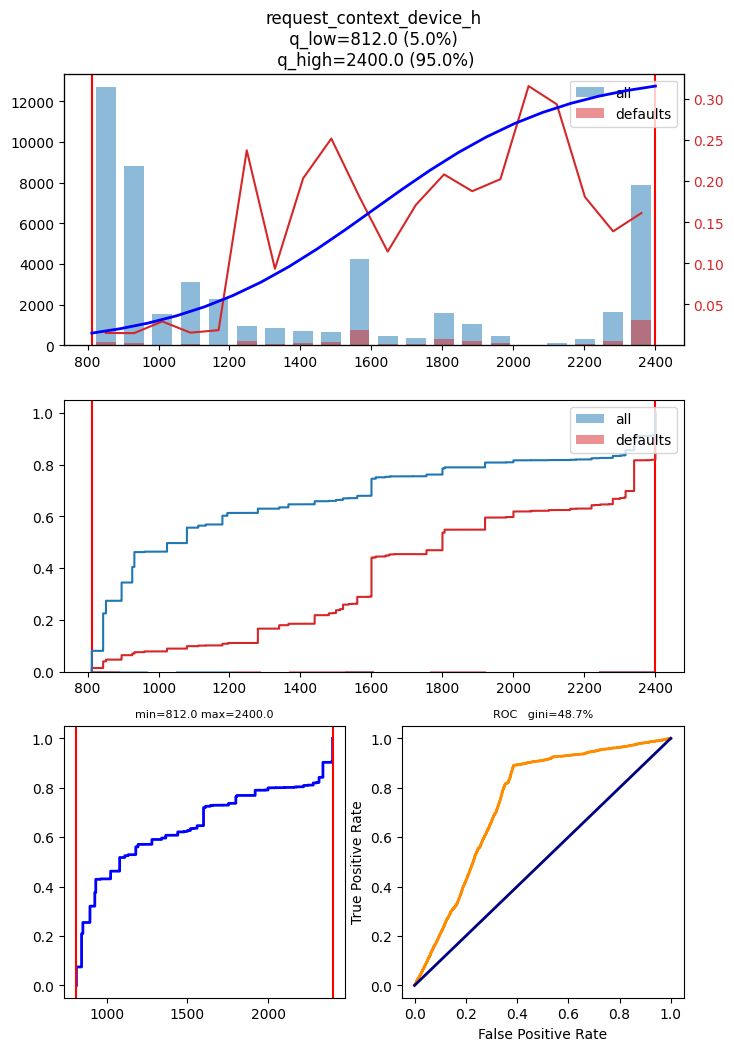

In [19]:
f_name = 'request_context_device_h'

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

Statistics->
 nan values->0  (0.0%)
 inf values->0  (0.0%)
min = 0.011409544
max = 229.231
after cutting: min =0.6914997
after cutting: max =14.0110038
Start plotting...
 min x for ROC 0.6914997 max x for ROC 14.0110038
 min y for ROC 0 max x for ROC 1
 nan x for ROC 0 nan x for ROC 0


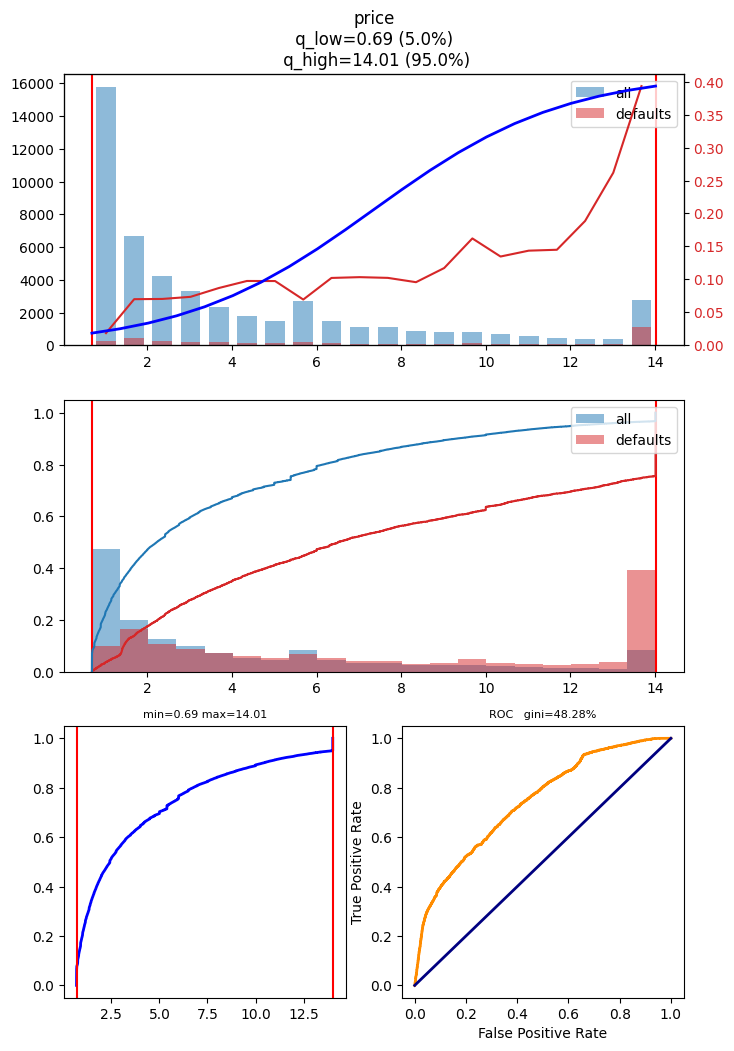

In [20]:
f_name =  'price'

if make_graphs_for_features:
  factor_utils.plot_factor(data, factor_name = f_name, value_col = f_name, target_col = "target", nbins = 20,
                         p_low = 0.05, p_high = 0.95, left_cut = None, right_cut = None, show_cut_graph = True)

#Creating new time-based features

In [21]:
time_feature = 'hour'
# Преобразование в синус и косинус
data['hour_sin'] = np.sin(2 * np.pi * data[time_feature] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data[time_feature] / 24)

#test
data_test['hour_sin'] = np.sin(2 * np.pi * data_test[time_feature] / 24)
data_test['hour_cos'] = np.cos(2 * np.pi * data_test[time_feature] / 24)

<Axes: >

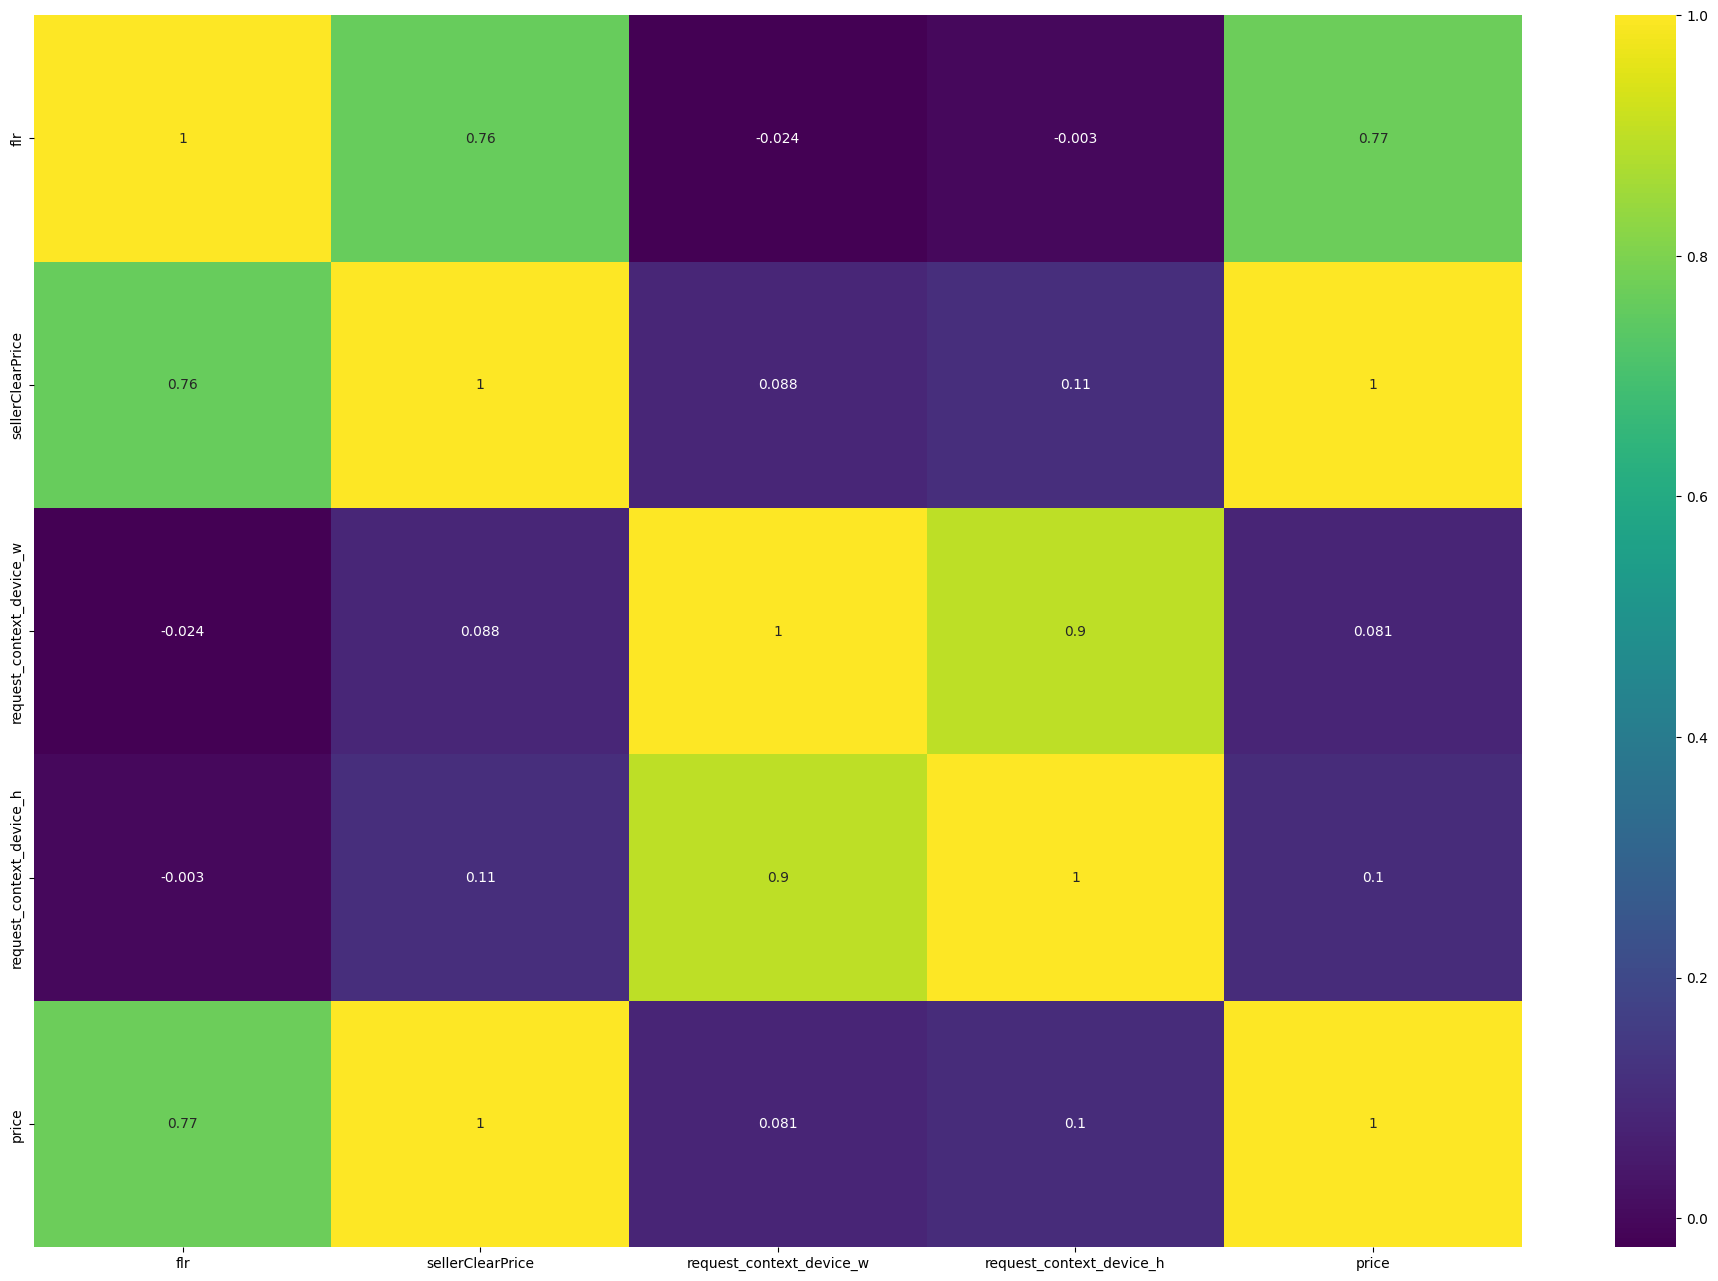

In [22]:
plt.figure(figsize=(24, 16))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='viridis')

 Result -> It is evident that three features—**flr**, **sellerClearPrice**, and **price**—are highly correlated, as well as two features—**request_context_device_w** and **request_context_device_h**. Keeping all of them is not necessarily a problem, but if we later decide to use a logistic regression model, it would be better to select only one feature from each of these groups to reduce the variance in the estimation of the logistic regression coefficients.



#### Adding new features to the dataset, applying a logistic transformation

In [23]:
for fName in numeric_features:
    x = data[fName]
    p_low = 0.05
    p_high = 0.95
    low_quant = x.quantile(p_low)
    high_quant = x.quantile(p_high)
    logistic_factor = factor_utils.logistic_transformation(x, low_quant, high_quant)['values']
    data.drop(columns = fName, inplace = True)
    newName = fName + "_logistic"
    data[newName] = logistic_factor

#test
    x = data_test[fName]
    logistic_factor = factor_utils.logistic_transformation(x, low_quant, high_quant)['values']
    data_test.drop(columns = fName, inplace=True)
    newName = fName + "_logistic"
    data_test[newName] = logistic_factor

In [24]:
numeric_features_selected = ['flr_logistic', 'sellerClearPrice_logistic', 'request_context_device_w_logistic', 'request_context_device_h_logistic', 'price_logistic']

In [25]:
data.columns

Index(['target', 'hour', 'ssp', 'dsp', 'auctionBidFloorSource', 'sdk',
       'sdkver', 'bundle', 'os', 'lang', 'country', 'region',
       'bidderFlrPolicy', 'adt', 'dc', 'contype',
       'request_context_device_type', 'ifa', 'hour_sin', 'hour_cos',
       'flr_logistic', 'sellerClearPrice_logistic',
       'request_context_device_w_logistic',
       'request_context_device_h_logistic', 'price_logistic'],
      dtype='object')

## ✔️ One factor analysis

## ✔️ One factor analysis  ( `categorical_features`)

In [26]:
categoric_features

['ssp',
 'dsp',
 'auctionBidFloorSource',
 'sdk',
 'sdkver',
 'bundle',
 'os',
 'lang',
 'country',
 'region',
 'bidderFlrPolicy',
 'adt',
 'dc',
 'contype',
 'request_context_device_type',
 'ifa']

In [27]:
factor_name = 'dsp'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

In [28]:
df

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
1,80,30055,29523,532,0.64,0.13,1.63,0.85,0.01,0.60,30055,0.60
0,76,8268,5432,2836,0.12,0.67,-1.74,0.96,0.06,0.17,38323,0.77
5,41,5106,5059,47,0.11,0.01,2.29,0.23,0.00,0.10,43429,0.87
6,122,2729,2227,502,0.05,0.12,-0.90,0.06,0.01,0.05,46158,0.92
2,87,1317,1285,32,0.03,0.01,1.31,0.03,0.00,0.03,47475,0.95
9,104,637,608,29,0.01,0.01,0.66,0.00,0.00,0.01,48112,0.96
7,227,591,576,15,0.01,0.00,1.26,0.01,0.00,0.01,48703,0.97
4,46,299,279,20,0.01,0.00,0.25,0.00,0.00,0.01,49002,0.98
10,132,298,296,2,0.01,0.00,2.61,0.02,0.00,0.01,49300,0.99
8,180,291,124,167,0.00,0.04,-2.68,0.10,0.00,0.01,49591,0.99


Each group (bin) should contain a sufficient number of observations to make the WOE statistically meaningful. A common recommendation is to have at least 3-5% of the total observations in each bin. So we keep only first top values with more than 3% of observations


  other values will be coded as "OTHER"

In [29]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])

In [30]:
values_to_keep

[80, 76, 41, 122]

In [31]:
# values_to_keep = [80, 76, 41, 122]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['dsp_grouped'] = data['dsp'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['dsp_grouped'] = data_test['dsp'].apply(lambda x: map_dict.get(x, default_value))

In [32]:
factor_name = 'dsp_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

In [33]:
df

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
1,80,30055,29523,532,0.64,0.13,1.63,0.85,0.01,0.60,30055,0.60
0,76,8268,5432,2836,0.12,0.67,-1.74,0.96,0.06,0.17,38323,0.77
3,41,5106,5059,47,0.11,0.01,2.29,0.23,0.00,0.10,43429,0.87
2,OTHER,3842,3548,294,0.08,0.07,0.10,0.00,0.01,0.08,47271,0.95
4,122,2729,2227,502,0.05,0.12,-0.90,0.06,0.01,0.05,50000,1.00


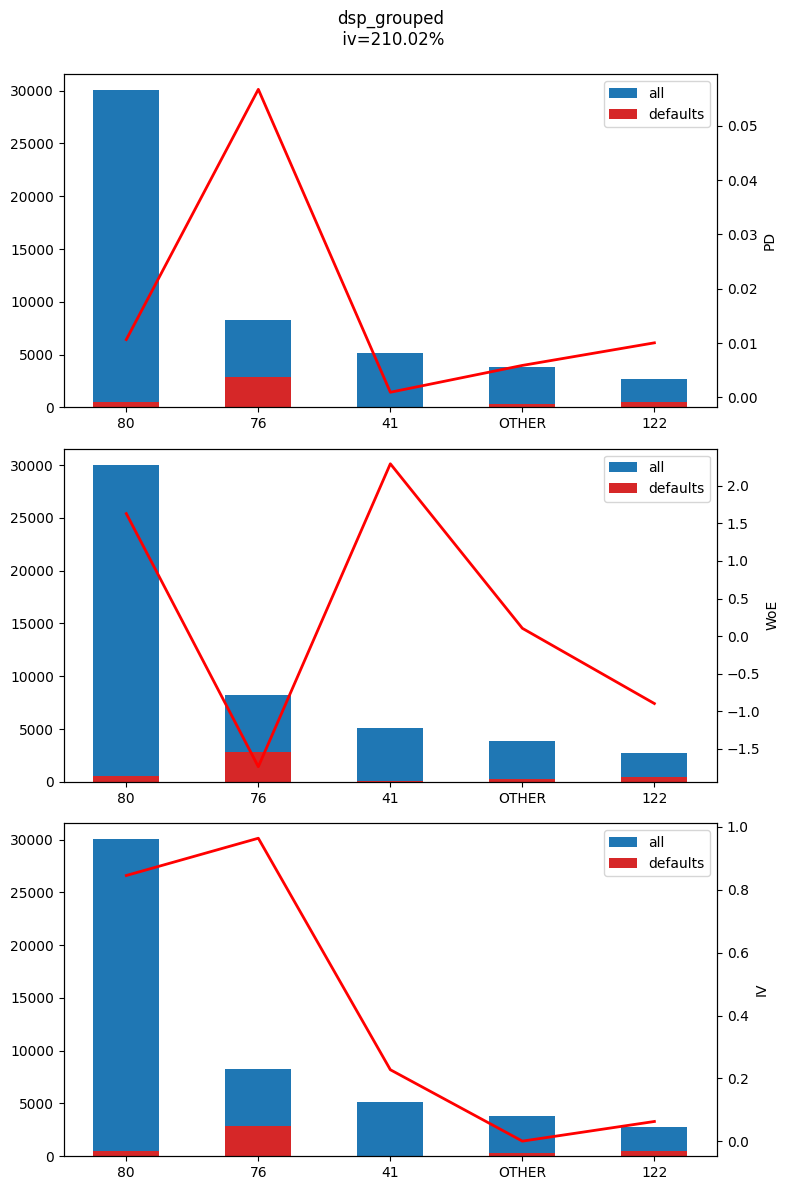

In [34]:
factor_utils.plot_iv(df, iv, factor_name)

In [35]:
factor_name = 'sdkver'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

In [36]:
df

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
1,2.4.0.2,27210,26780,430,0.58,0.10,1.75,0.84,0.01,0.54,27210,0.54
0,2.5.0,19078,15663,3415,0.34,0.81,-0.86,0.40,0.07,0.38,46288,0.93
3,2.4.0.0,952,941,11,0.02,0.00,2.06,0.04,0.00,0.02,47240,0.94
4,2.3.3,880,702,178,0.02,0.04,-1.01,0.03,0.00,0.02,48120,0.96
2,2.2.0,868,762,106,0.02,0.03,-0.41,0.00,0.00,0.02,48988,0.98
9,2.1.0.0,313,307,6,0.01,0.00,1.55,0.01,0.00,0.01,49301,0.99
5,1.9.5.0,113,113,0,0.00,0.00,0.00,0.00,0.00,0.00,49414,0.99
13,2.1.5,106,79,27,0.00,0.01,-1.31,0.01,0.00,0.00,49520,0.99
11,2.3.0.2,104,103,1,0.00,0.00,2.25,0.00,0.00,0.00,49624,0.99
6,2.1.9,86,71,15,0.00,0.00,-0.83,0.00,0.00,0.00,49710,0.99


In [37]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["	2.4.0.2","2.5.0" , "2.4.0.0","2.2.0", "2.3.3", "2.1.0.0" ]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHERS"
data['sdkver_grouped'] = data['sdkver'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['sdkver_grouped'] = data_test['sdkver'].apply(lambda x: map_dict.get(x, default_value))

In [38]:
factor_name = 'sdkver_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)

## Apply WOE (Weight of Evidence) transformation

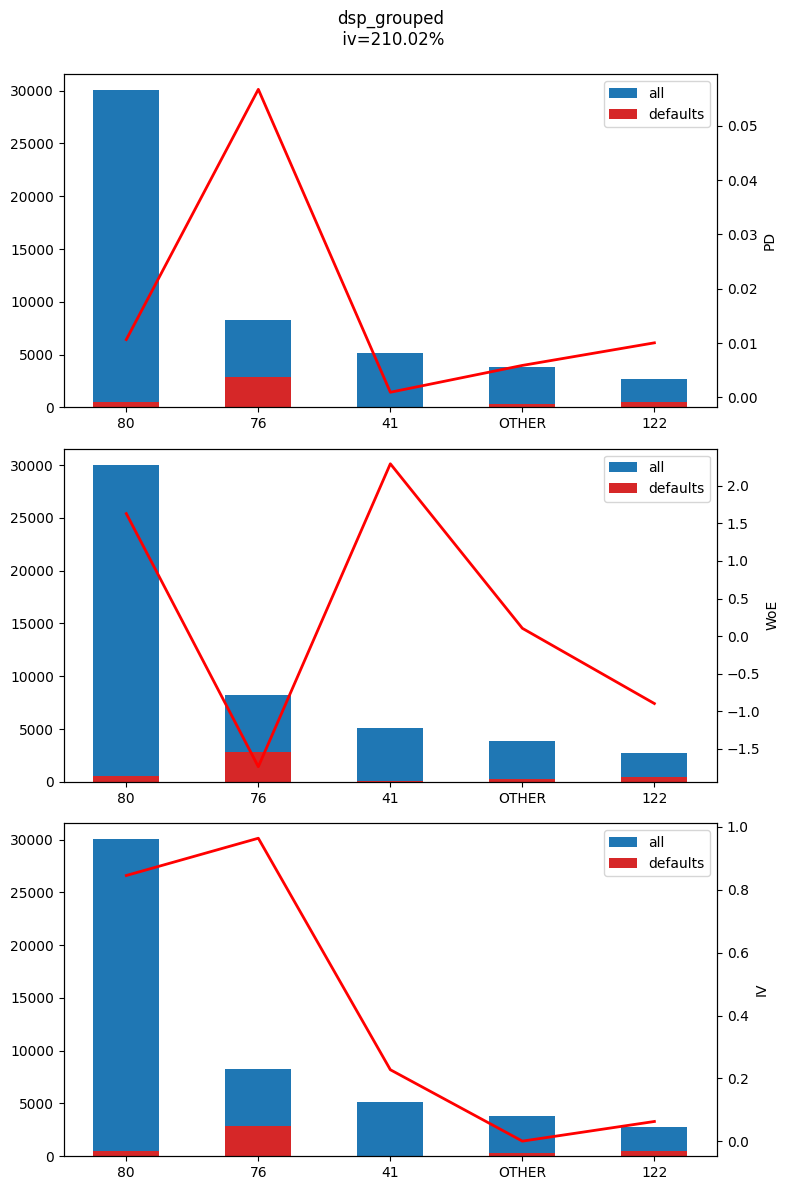

In [39]:
factor_name = 'dsp_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

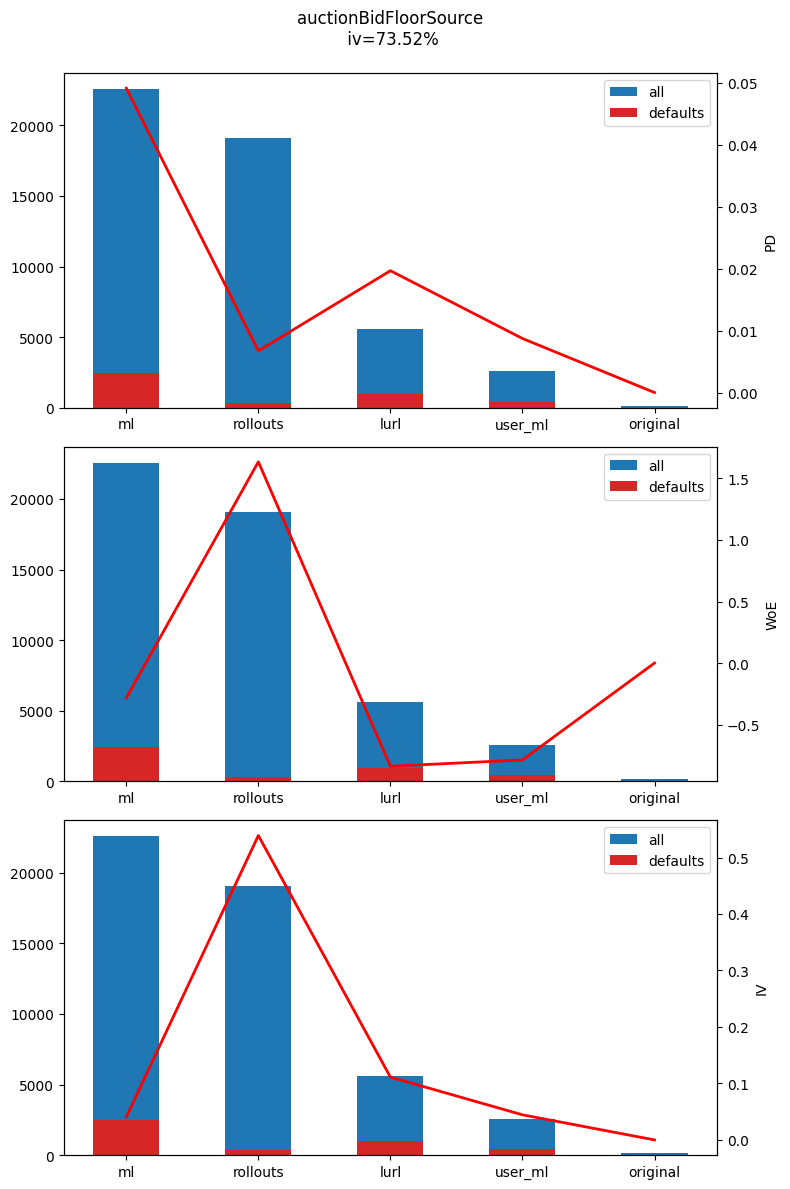

In [40]:
factor_name = 'auctionBidFloorSource'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

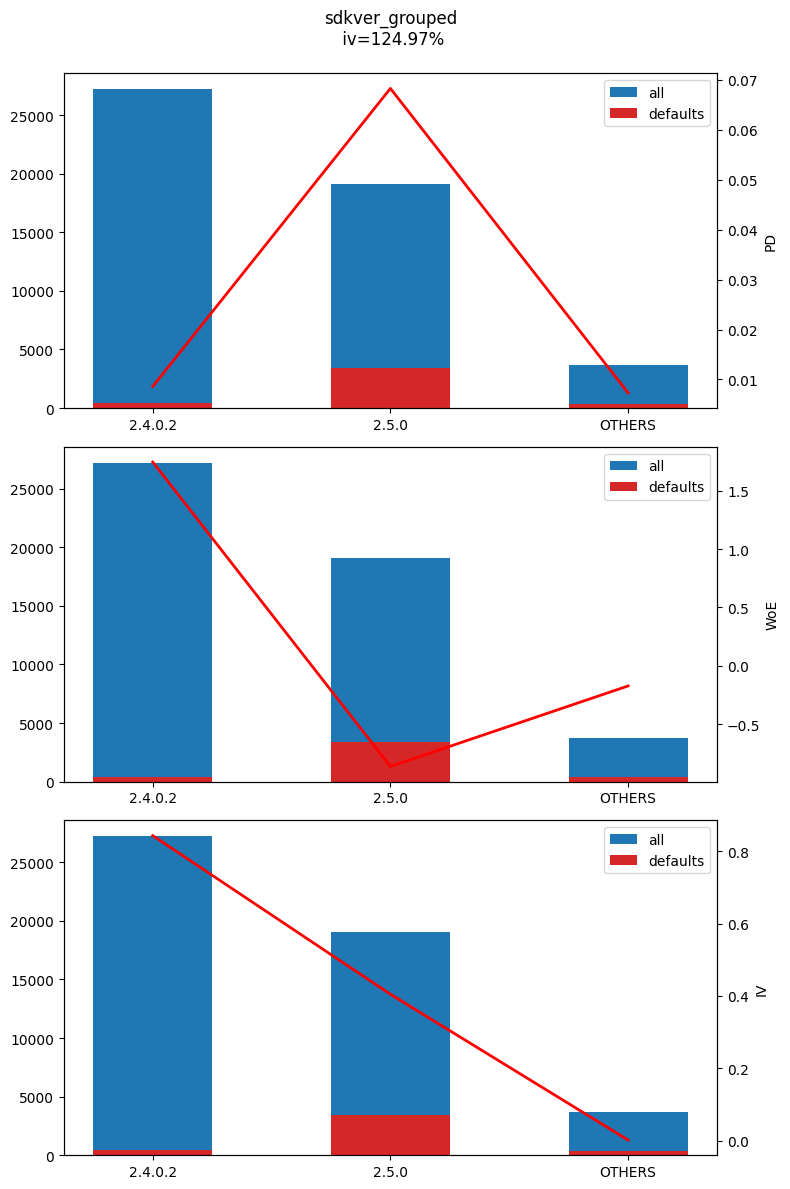

In [41]:
factor_name = 'sdkver_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

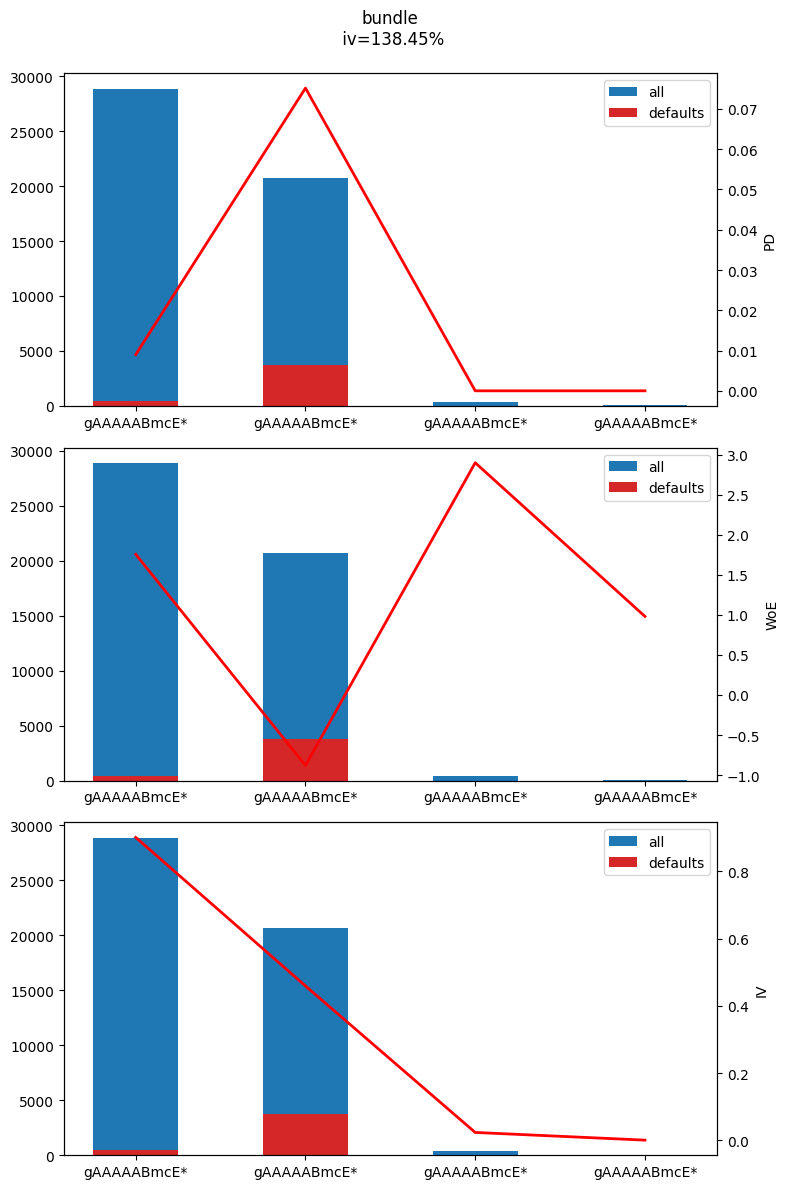

In [42]:
factor_name = 'bundle'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

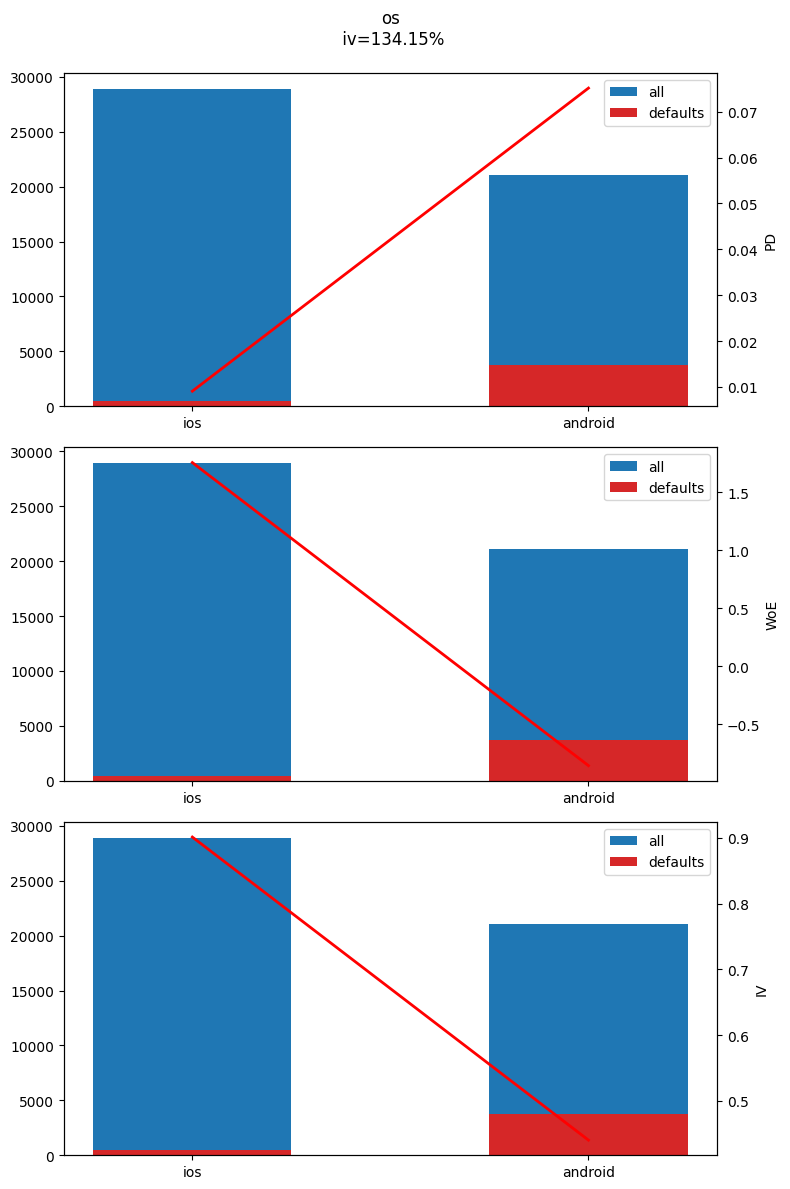

In [43]:
factor_name = 'os'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

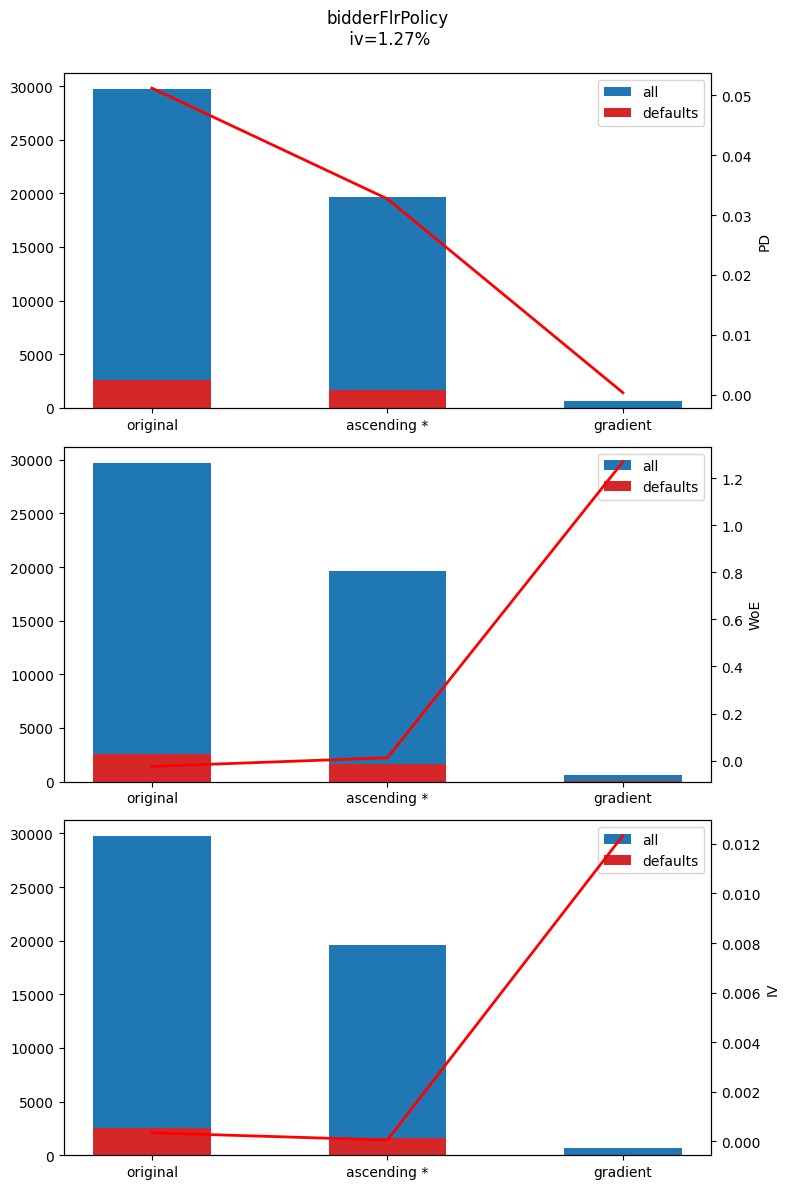

In [44]:
factor_name = 'bidderFlrPolicy'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

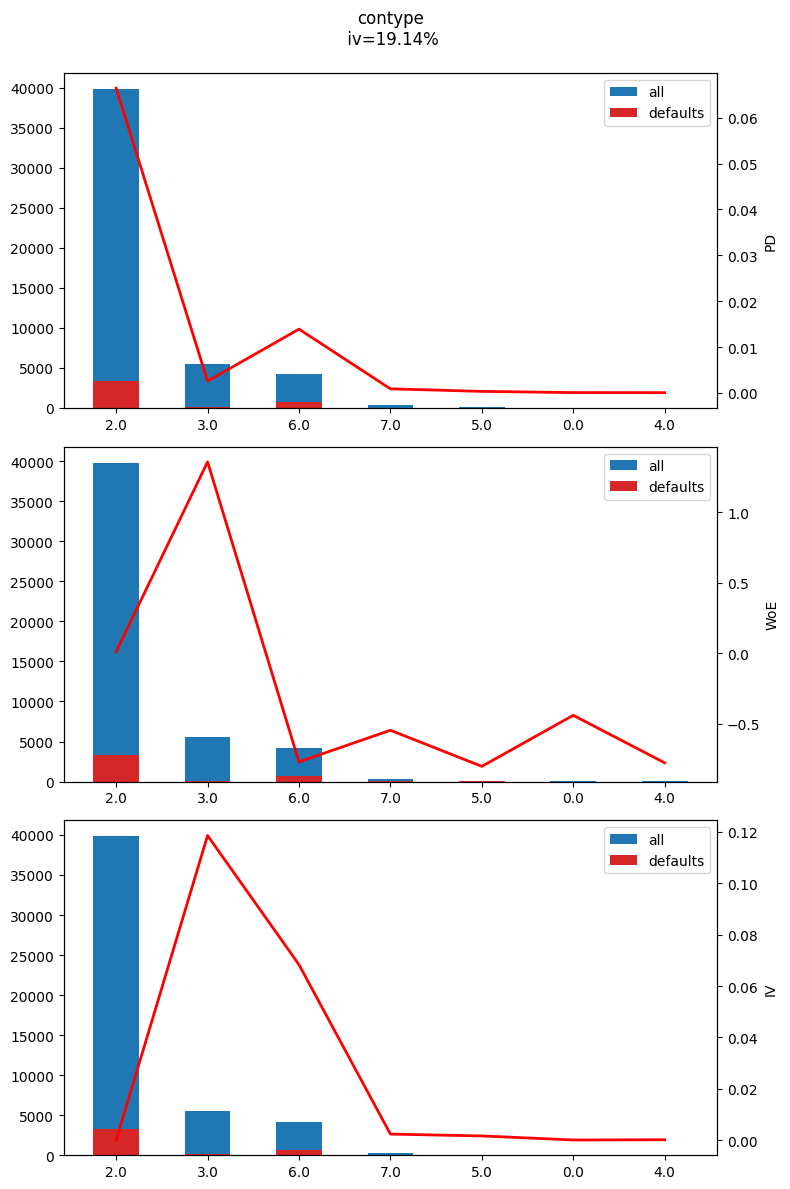

In [45]:
factor_name = 'contype'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

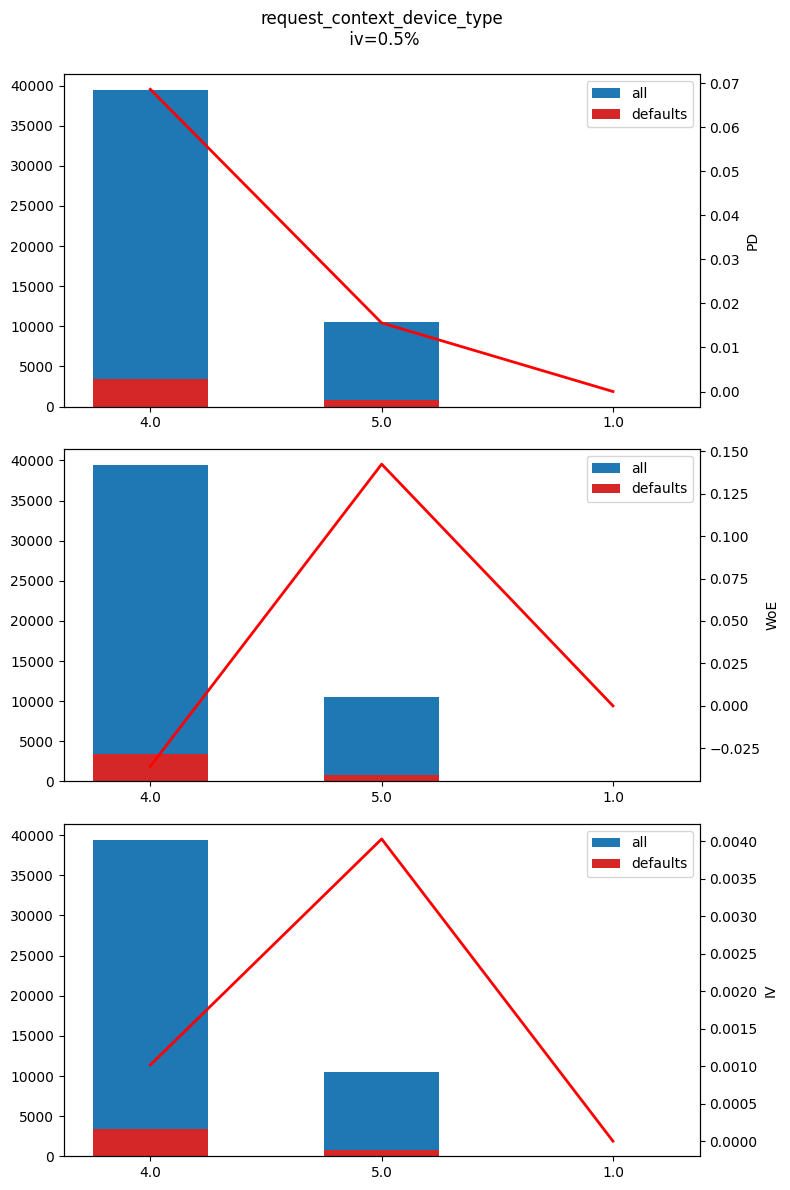

In [46]:
factor_name = 'request_context_device_type'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


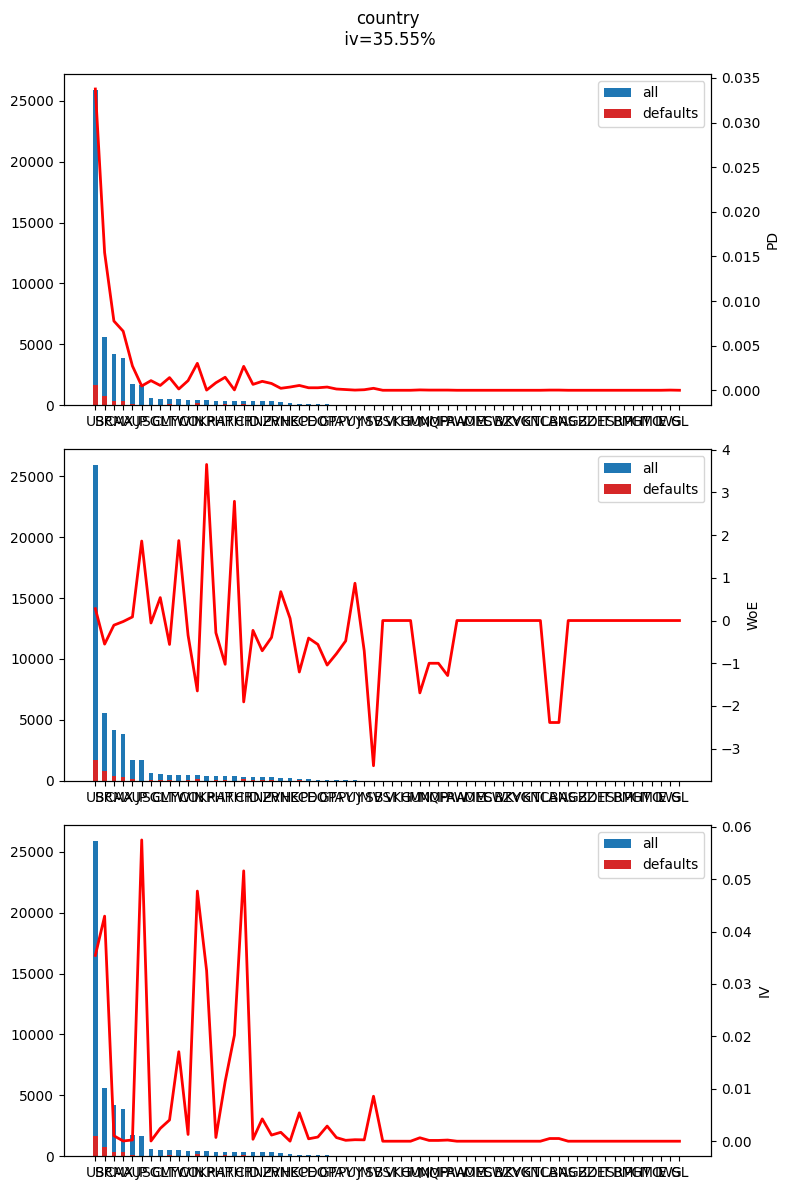

In [47]:
factor_name = 'country'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

In [48]:
df[0:40]

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
3,US,25902,24214,1688,0.53,0.40,0.28,0.04,0.03,0.52,25902,0.52
0,BR,5596,4825,771,0.11,0.18,-0.55,0.04,0.02,0.11,31498,0.63
4,CA,4172,3784,388,0.08,0.09,-0.11,0.00,0.01,0.08,35670,0.71
2,MX,3845,3514,331,0.08,0.08,-0.02,0.00,0.01,0.08,39515,0.79
1,AU,1745,1609,136,0.04,0.03,0.08,0.00,0.00,0.03,41260,0.83
7,JP,1700,1676,24,0.04,0.01,1.86,0.06,0.00,0.03,42960,0.86
6,SG,608,554,54,0.01,0.01,-0.06,0.00,0.00,0.01,43568,0.87
15,CL,529,502,27,0.01,0.01,0.54,0.00,0.00,0.01,44097,0.88
18,MY,512,441,71,0.01,0.02,-0.56,0.00,0.00,0.01,44609,0.89
21,TW,501,494,7,0.01,0.00,1.87,0.02,0.00,0.01,45110,0.90


In [49]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["US", "BR", "CA", "MX", "JP", "AU"]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['country_grouped'] = data['country'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['country_grouped'] = data_test['country'].apply(lambda x: map_dict.get(x, default_value))

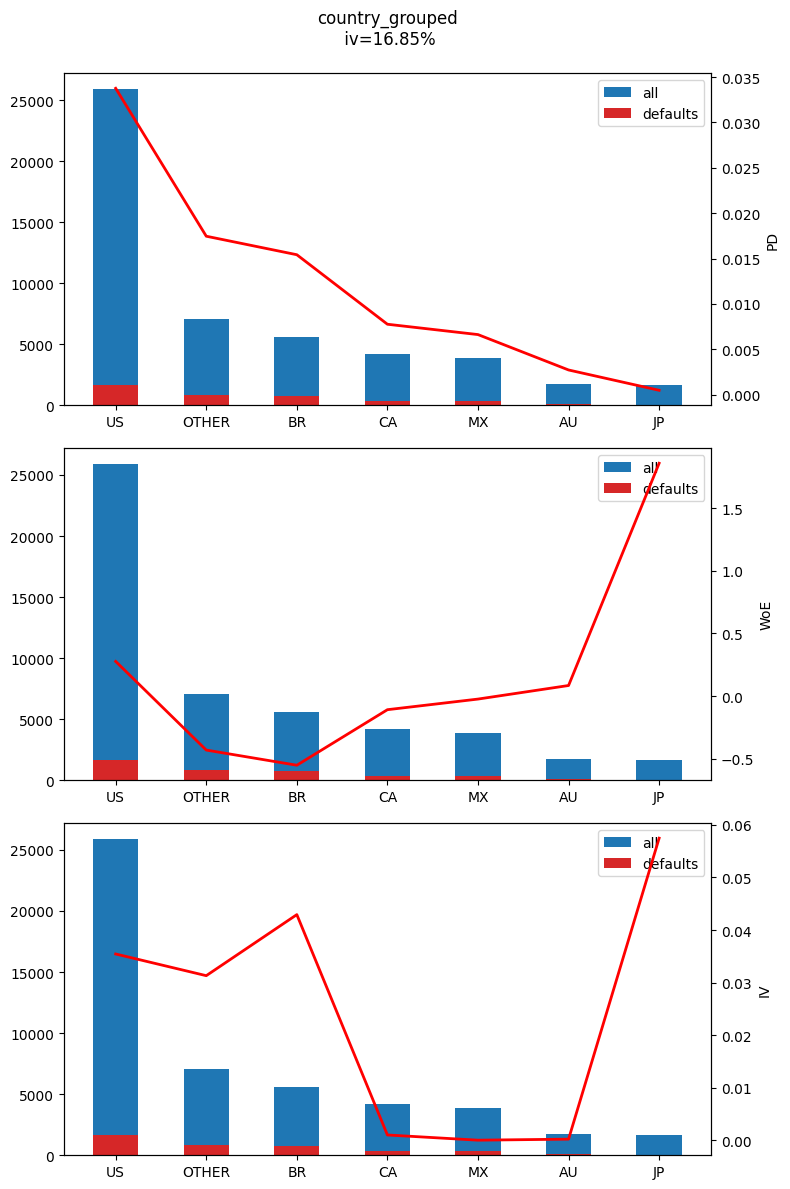

In [50]:
factor_name = 'country_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


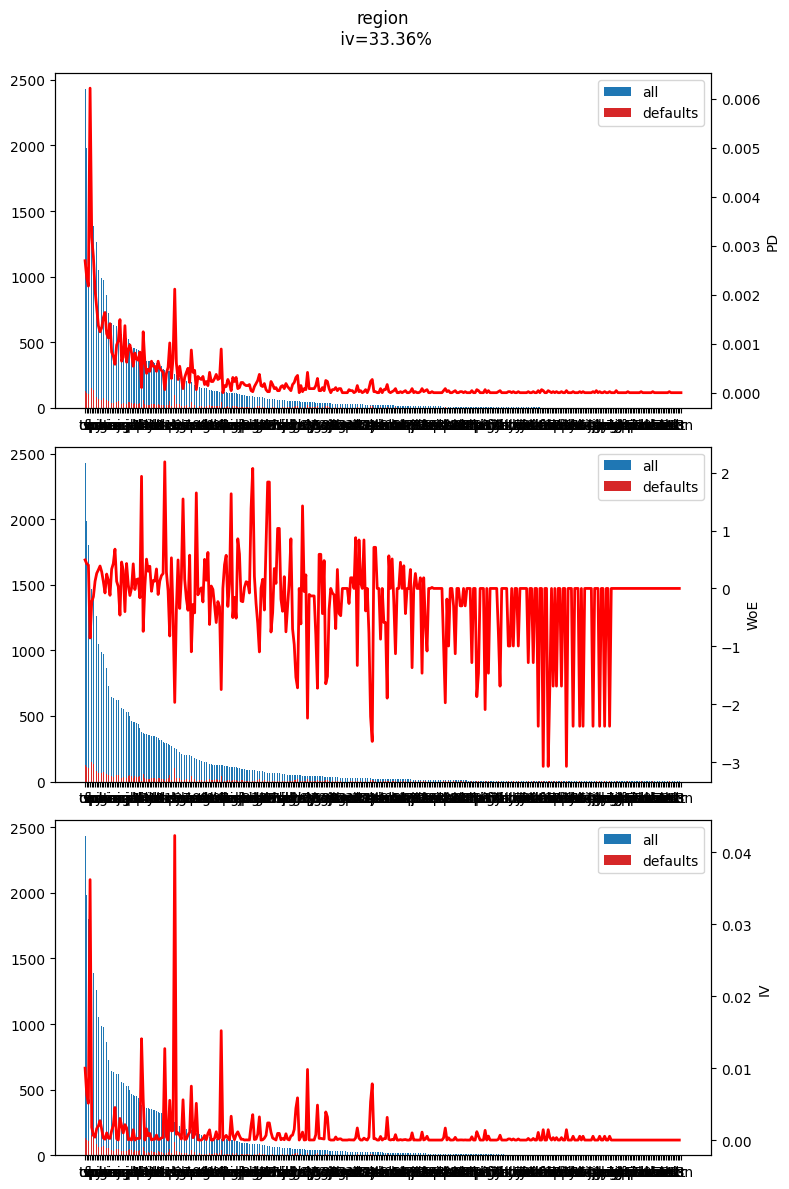

In [51]:
factor_name = 'region'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

In [52]:
df[0:20]

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
51,tx,2431,2301,130,0.05,0.03,0.49,0.01,0.00,0.05,2431,0.05
20,ca,1984,1871,113,0.04,0.03,0.43,0.01,0.00,0.04,4415,0.09
34,fl,1802,1697,105,0.04,0.03,0.40,0.01,0.00,0.04,6217,0.13
7,sp,1678,1378,300,0.03,0.07,-0.86,0.04,0.01,0.03,7895,0.16
6,qc,1468,1315,153,0.03,0.04,-0.23,0.00,0.00,0.03,9363,0.19
11,on,1389,1255,134,0.03,0.03,-0.14,0.00,0.00,0.03,10752,0.22
37,ny,1337,1236,101,0.03,0.02,0.12,0.00,0.00,0.03,12089,0.25
5,pa,1263,1179,84,0.03,0.02,0.26,0.00,0.00,0.03,13352,0.28
39,oh,1050,984,66,0.02,0.02,0.32,0.00,0.00,0.02,14402,0.30
32,il,1016,956,60,0.02,0.01,0.39,0.00,0.00,0.02,15418,0.32


In [53]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["tx", "ca", "fl", "sp"]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['region_grouped'] = data['region'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['region_grouped'] = data_test['region'].apply(lambda x: map_dict.get(x, default_value))

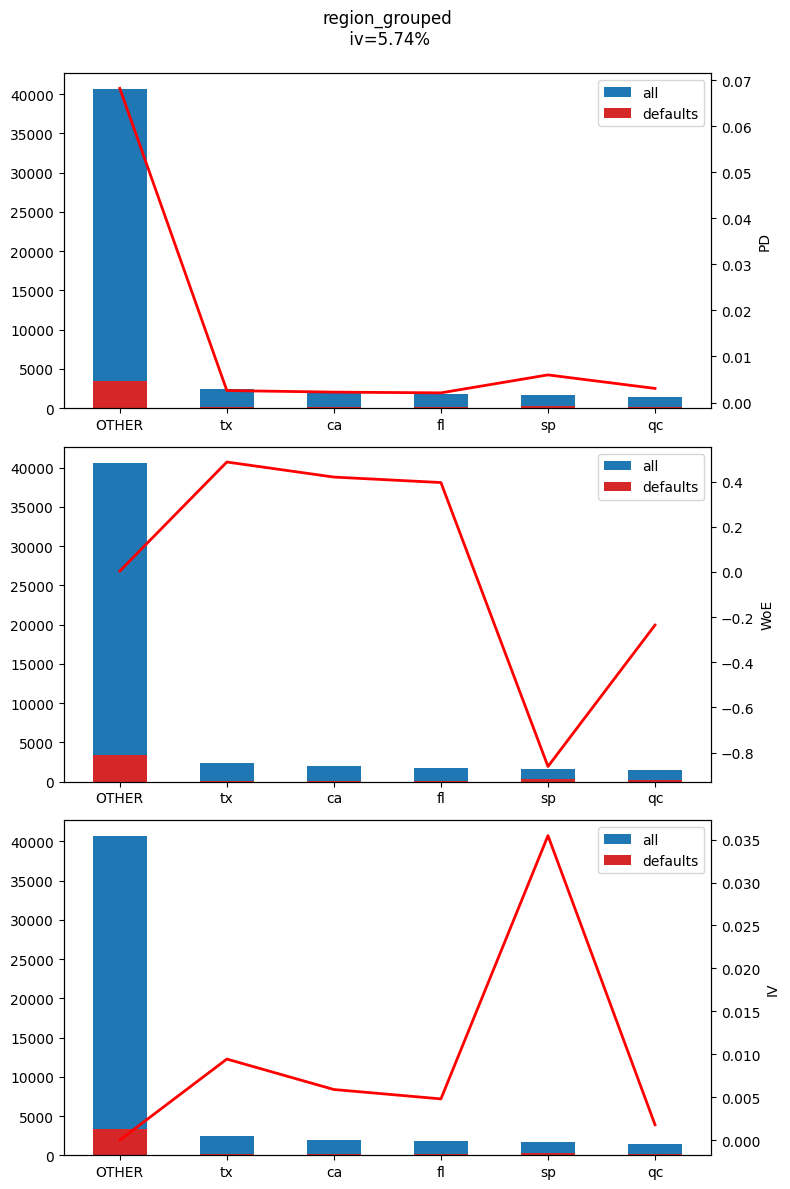

In [54]:
factor_name = 'region_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


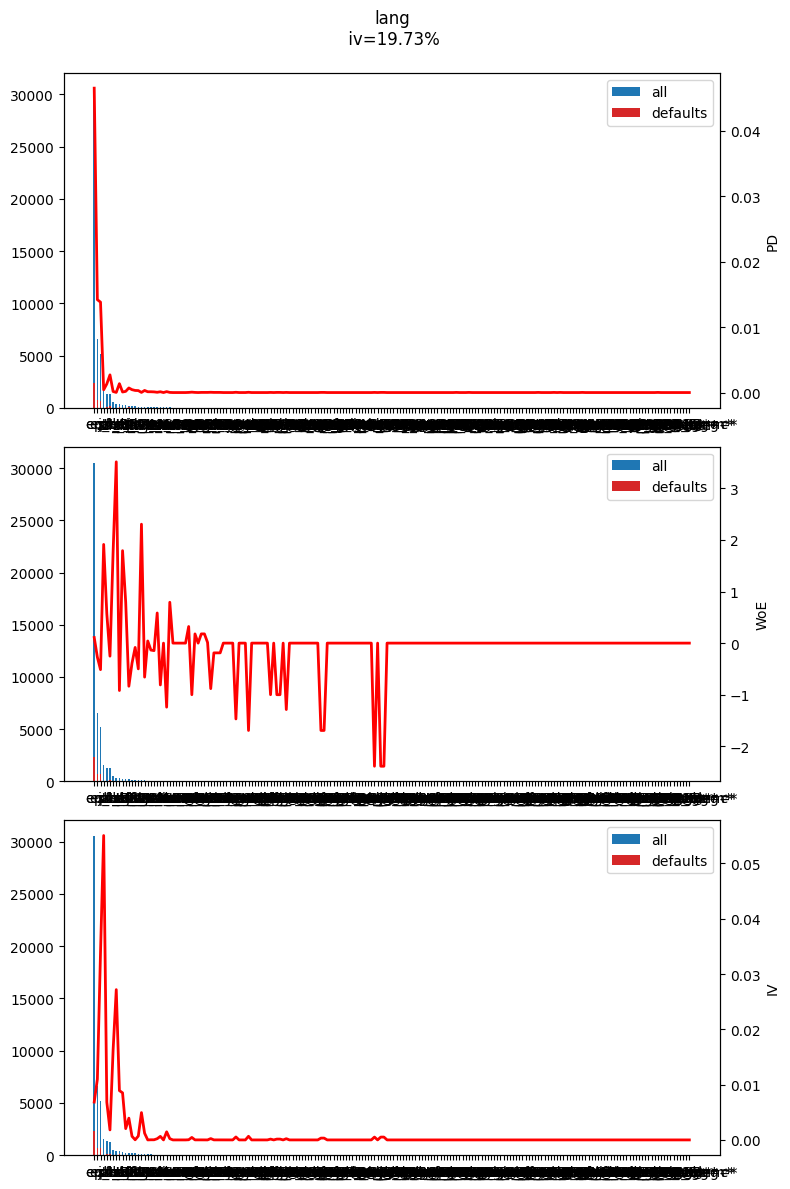

In [55]:
factor_name = 'lang'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

In [56]:
df[0:20]

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
1,en,30525,28198,2327,0.62,0.55,0.11,0.01,0.05,0.61,30525,0.61
2,es,6587,5877,710,0.13,0.17,-0.27,0.01,0.01,0.13,37112,0.74
0,pt,5184,4493,691,0.10,0.16,-0.51,0.03,0.01,0.10,42296,0.85
5,ja,1567,1546,21,0.03,0.00,1.91,0.06,0.00,0.03,43863,0.88
7,en_US,1333,1267,66,0.03,0.02,0.57,0.01,0.00,0.03,45196,0.90
8,fr,1275,1140,135,0.02,0.03,-0.25,0.00,0.00,0.03,46471,0.93
3,zh,517,509,8,0.01,0.00,1.77,0.02,0.00,0.01,46988,0.94
13,ko,366,365,1,0.01,0.00,3.51,0.03,0.00,0.01,47354,0.95
16,pt_BR,363,295,68,0.01,0.02,-0.92,0.01,0.00,0.01,47717,0.95
12,th,265,261,4,0.01,0.00,1.79,0.01,0.00,0.01,47982,0.96


In [57]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["en", "es", "pt", "ja"]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['lang_grouped'] = data['lang'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['lang_grouped'] = data_test['lang'].apply(lambda x: map_dict.get(x, default_value))

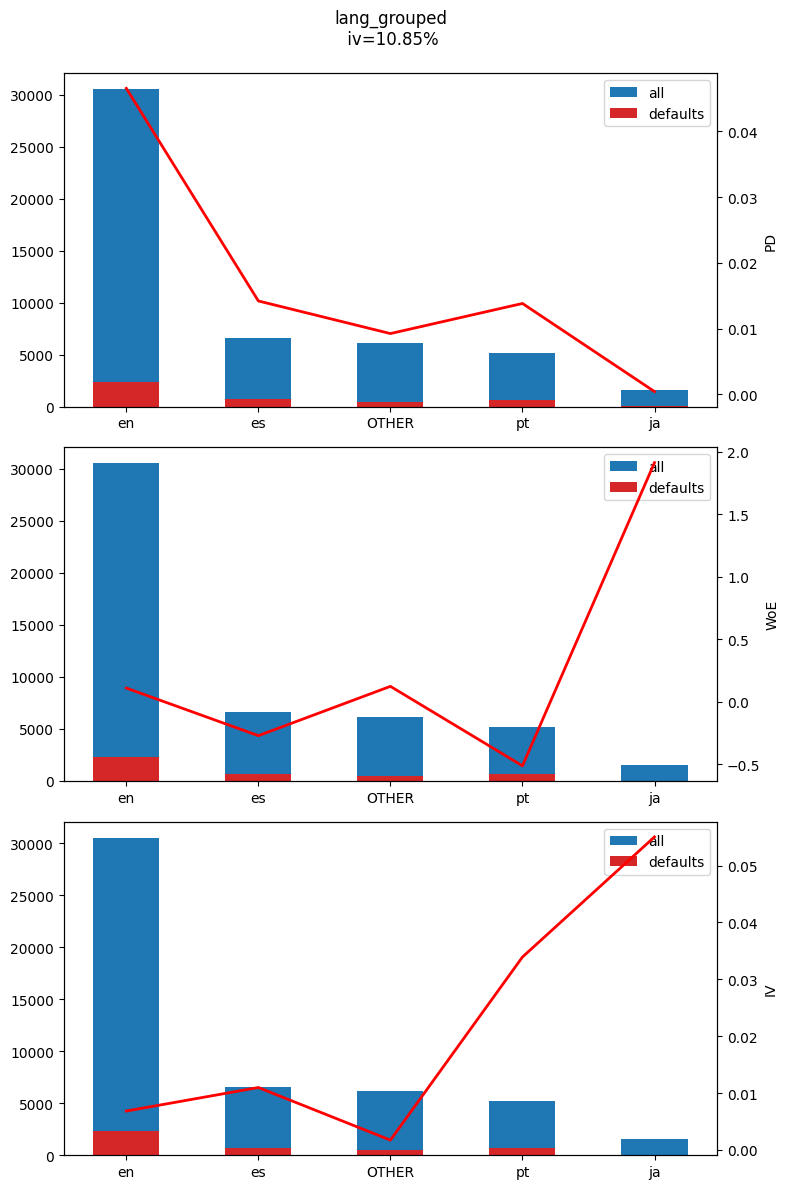

In [58]:
factor_name = 'lang_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
woe_mapping = dict(zip(df["Value"], df["WoE"]))
data[factor_name + '_woe'] = data[factor_name].map(woe_mapping)
factor_utils.plot_iv(df, iv, factor_name)

#test
data_test[factor_name + '_woe'] = data_test[factor_name].map(woe_mapping)

In [59]:
data['lang'].unique()

array(['pt', 'en', 'es', 'zh', 'en_CA', 'ja', 'es_MX', 'en_US', 'fr',
       'ar_US', 'fr_CA', 'id', 'th', 'ko', 'ja_JP', 'th_TH', 'pt_BR',
       'en_AU', 'zh_CN_#Hans', 'en_TW@calendar=buddhist', 'in_ID',
       'ar_SA@calendar=gregorian;numbers=latn', 'es_CO', 'vi', 'es_US',
       'en_AU@rg=uszzzz', 'es_ES', 'zh-Hans_MY', 'zh_TW',
       'en_GB@rg=auzzzz', 'zh_TW_#Hant', 'en_PH', 'zh_HK_#Hant', 'en_SG',
       'nl_BE', 'ru', 'zh-Hans_CA', 'th_TH@calendar=gregorian',
       'en_TH@calendar=gregorian', 'ru_TH@calendar=gregorian',
       'zh-Hant_CA', 'ja_JP@calendar=japanese', 'sv',
       'en_AF@calendar=gregorian', 'zh_GB_#Hant', 'es_CL', 'id_ID',
       'vi_VN', 'es_PE', 'en_GB', 'en_IN', 'ro', 'en_MY', 'nv',
       'en_US_#u-mu-celsius', 'es_PA@calendar=japanese', 'ko-Kore_KR',
       'ms', 'ar', 'es_CR', 'zh-Hant_CN', 'en_PR', 'it',
       'en_US@rg=inzzzz', 'fr_CA@rg=uszzzz', 'ko_KR', 'pt_US',
       'zh-Hans_US', 'en_IE@rg=uszzzz', 'en_IN@rg=uszzzz',
       'en_US@rg=auzzzz', 

Create a new feature by refining only the first letters before the underscore

In [60]:
data['lang2'] = data['lang'].apply(lambda x: x.split('_')[0].split('-')[0])
data_test['lang2'] = data_test['lang'].apply(lambda x: x.split('_')[0].split('-')[0])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


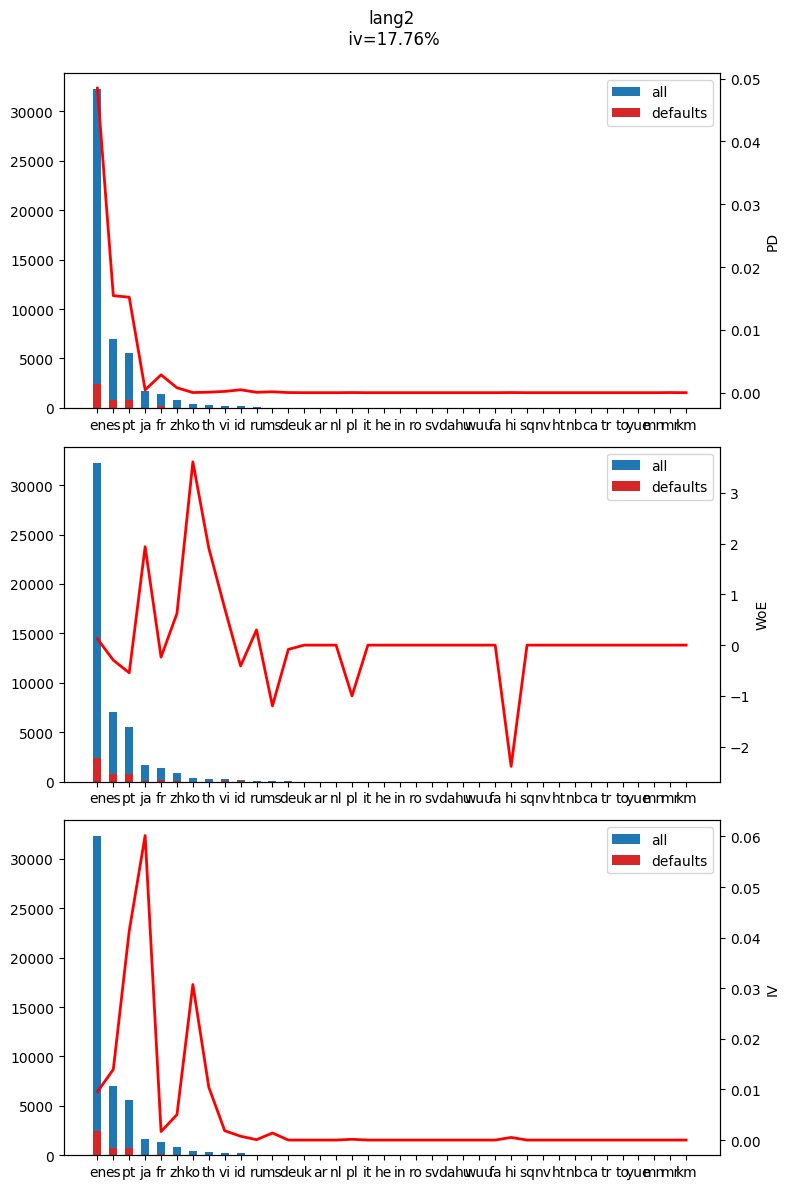

In [61]:
factor_name = 'lang2'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

In [62]:
df

,Value,All,Good,Bad,Distr_Good,Distr_Bad,WoE,IV,PD,All_proc,All_cumm,All_cumm_proc
1,en,32282,29858,2424,0.65,0.58,0.12,0.01,0.05,0.65,32282,0.65
2,es,7012,6240,772,0.14,0.18,-0.30,0.01,0.02,0.14,39294,0.79
0,pt,5552,4792,760,0.10,0.18,-0.54,0.04,0.02,0.11,44846,0.90
4,ja,1683,1661,22,0.04,0.01,1.94,0.06,0.00,0.03,46529,0.93
5,fr,1361,1219,142,0.03,0.03,-0.24,0.00,0.00,0.03,47890,0.96
3,zh,831,792,39,0.02,0.01,0.62,0.01,0.00,0.02,48721,0.97
9,ko,402,401,1,0.01,0.00,3.61,0.03,0.00,0.01,49123,0.98
8,th,298,294,4,0.01,0.00,1.91,0.01,0.00,0.01,49421,0.99
11,vi,235,225,10,0.00,0.00,0.73,0.00,0.00,0.00,49656,0.99
7,id,189,166,23,0.00,0.01,-0.41,0.00,0.00,0.00,49845,1.00


In [63]:
values_to_keep = list(df.loc[df['All_proc']>=0.03,'Value'])
# values_to_keep = ["en", "es", "pt", "ja"]
map_dict = {item: item for item in values_to_keep}
default_value  = "OTHER"
data['lang2_grouped'] = data['lang2'].apply(lambda x: map_dict.get(x, default_value))

#test
data_test['lang2_grouped'] = data_test['lang2'].apply(lambda x: map_dict.get(x, default_value))

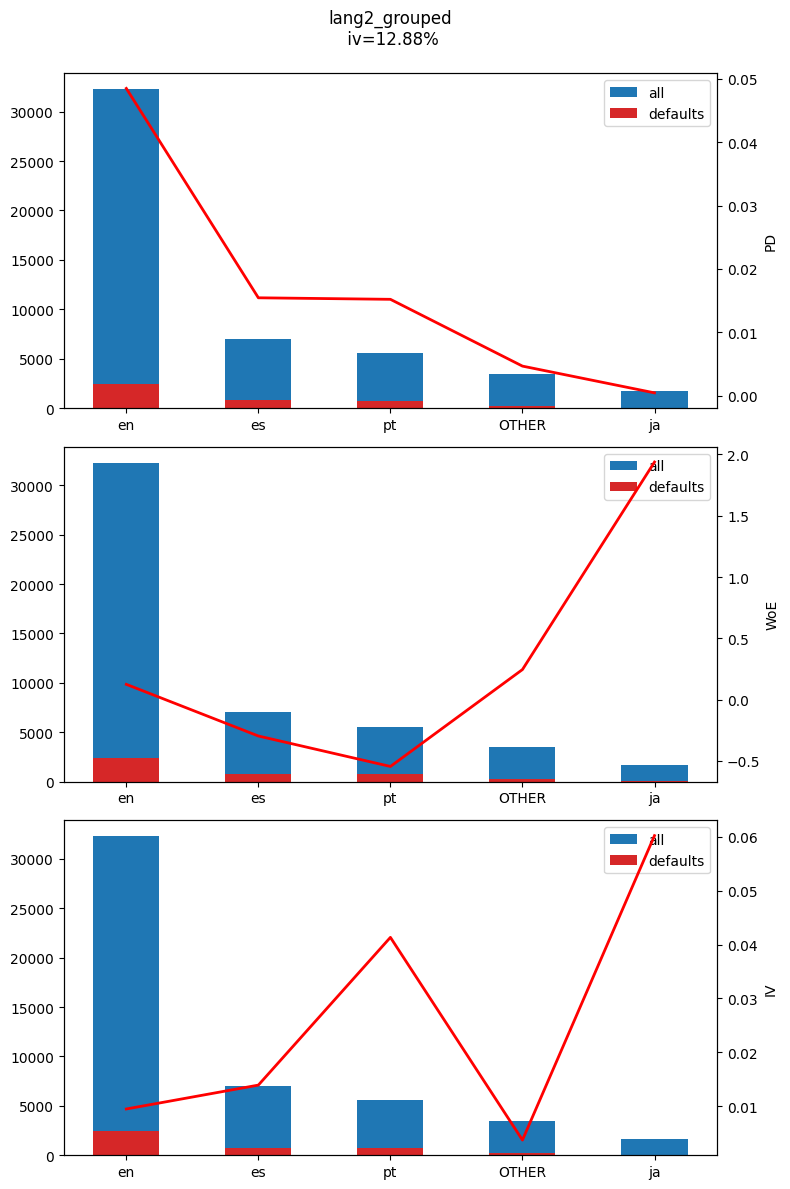

In [64]:
factor_name = 'lang2_grouped'
df, iv = factor_utils.calculate_woe_iv(data, factor_name, target_feature)
factor_utils.plot_iv(df, iv, factor_name)

There is minimal difference between the original 'lang' feature and the refined version. Therefore, we will keep only the 'lang' feature

In [65]:
to_delete_features = ['ssp','sdk','adt', 'dc',  'ifa']

numeric_logistic_features = ['flr_logistic', 'sellerClearPrice_logistic', 'request_context_device_w_logistic', 'request_context_device_h_logistic', 'price_logistic']
time_cos_sin_features = ['hour_cos', 'hour_sin']
categoric_woe_features = [ 'dsp_grouped_woe', 'auctionBidFloorSource_woe',  'sdkver_grouped_woe', 'bundle_woe',
                          'os_woe',  'bidderFlrPolicy_woe','contype_woe', 'request_context_device_type_woe',
                           'country_grouped', 'region_grouped', 'lang_grouped']

features_selected = numeric_logistic_features + time_cos_sin_features + categoric_woe_features

In [66]:
lst = []

IV_df = pd.DataFrame(columns=['Variable','IV'])
for col in categoric_woe_features:
    df, iv = factor_utils.calculate_woe_iv(data, col, target_feature)

    lst.append(df)
    IV_df = pd.concat([IV_df, pd.DataFrame([{
                "Variable" :col ,
                "IV" : iv,
                }])], ignore_index=True)
   # IV_df = IV_df.append({
    #            "Variable" :col ,
    #            "IV" : iv,
    #            },ignore_index=True)

<ipython-input-66-e306358ce6f6>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  IV_df = pd.concat([IV_df, pd.DataFrame([{


In [67]:
IV_df

,Variable,IV
0,dsp_grouped_woe,2.10
1,auctionBidFloorSource_woe,0.74
2,sdkver_grouped_woe,1.25
3,bundle_woe,1.38
4,os_woe,1.34
5,bidderFlrPolicy_woe,0.01
6,contype_woe,0.19
7,request_context_device_type_woe,0.01
8,country_grouped,0.17
9,region_grouped,0.06


### We can choose all categorical variables except two variables with the lowest IV

In [68]:
categoric_features_selected = ['dsp_grouped_woe',
 'auctionBidFloorSource_woe',
 'sdkver_grouped_woe',
 'bundle_woe',
 'os_woe',

 'contype_woe',

 'country_grouped_woe',
 'region_grouped_woe',
 'lang_grouped_woe']

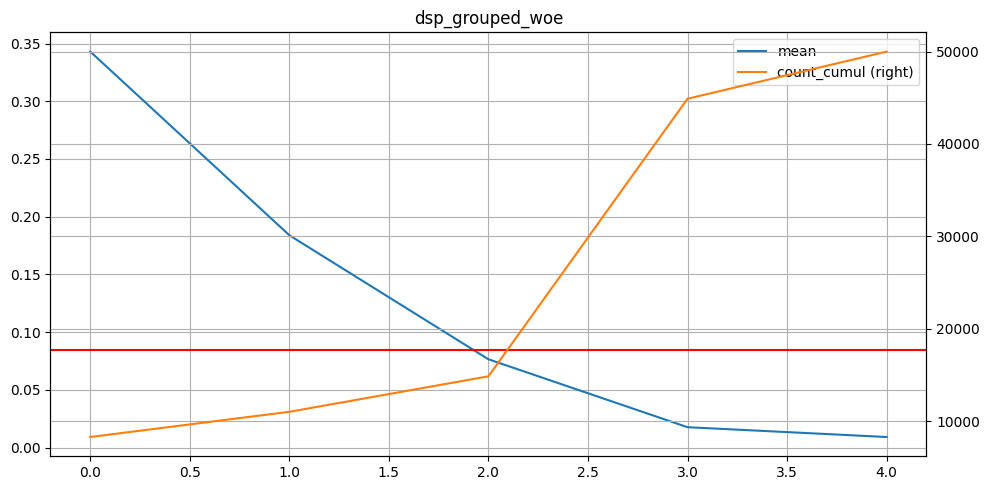

In [69]:
df1 = factor_utils.categorical_plot(data, 'dsp_grouped_woe', target_feature)

In [70]:
for feature_name in categoric_features_selected:
   data[feature_name] = data[feature_name].astype("object")

#test
   data_test[feature_name] = data_test[feature_name].astype("object")

In [71]:
features_selected = numeric_features_selected +  categoric_features_selected
features_selected

['flr_logistic',
 'sellerClearPrice_logistic',
 'request_context_device_w_logistic',
 'request_context_device_h_logistic',
 'price_logistic',
 'dsp_grouped_woe',
 'auctionBidFloorSource_woe',
 'sdkver_grouped_woe',
 'bundle_woe',
 'os_woe',
 'contype_woe',
 'country_grouped_woe',
 'region_grouped_woe',
 'lang_grouped_woe']

### Refining the dataset by deleting unselected features

In [72]:
all_columns = features_selected + [target_feature]
all_columns
data = data[all_columns]

#test
data_test = data_test[all_columns]

## 📈 How  features correlate with the target variable?

In [73]:
data.corr()[target_feature].drop(target_feature).sort_values().hvplot.barh(
    width=600, height=400,
    title="Correlation between Target and Numeric Features",
    ylabel='Correlation', xlabel='Numerical Features',
)

:Bars   [index]   (target)

<Axes: >

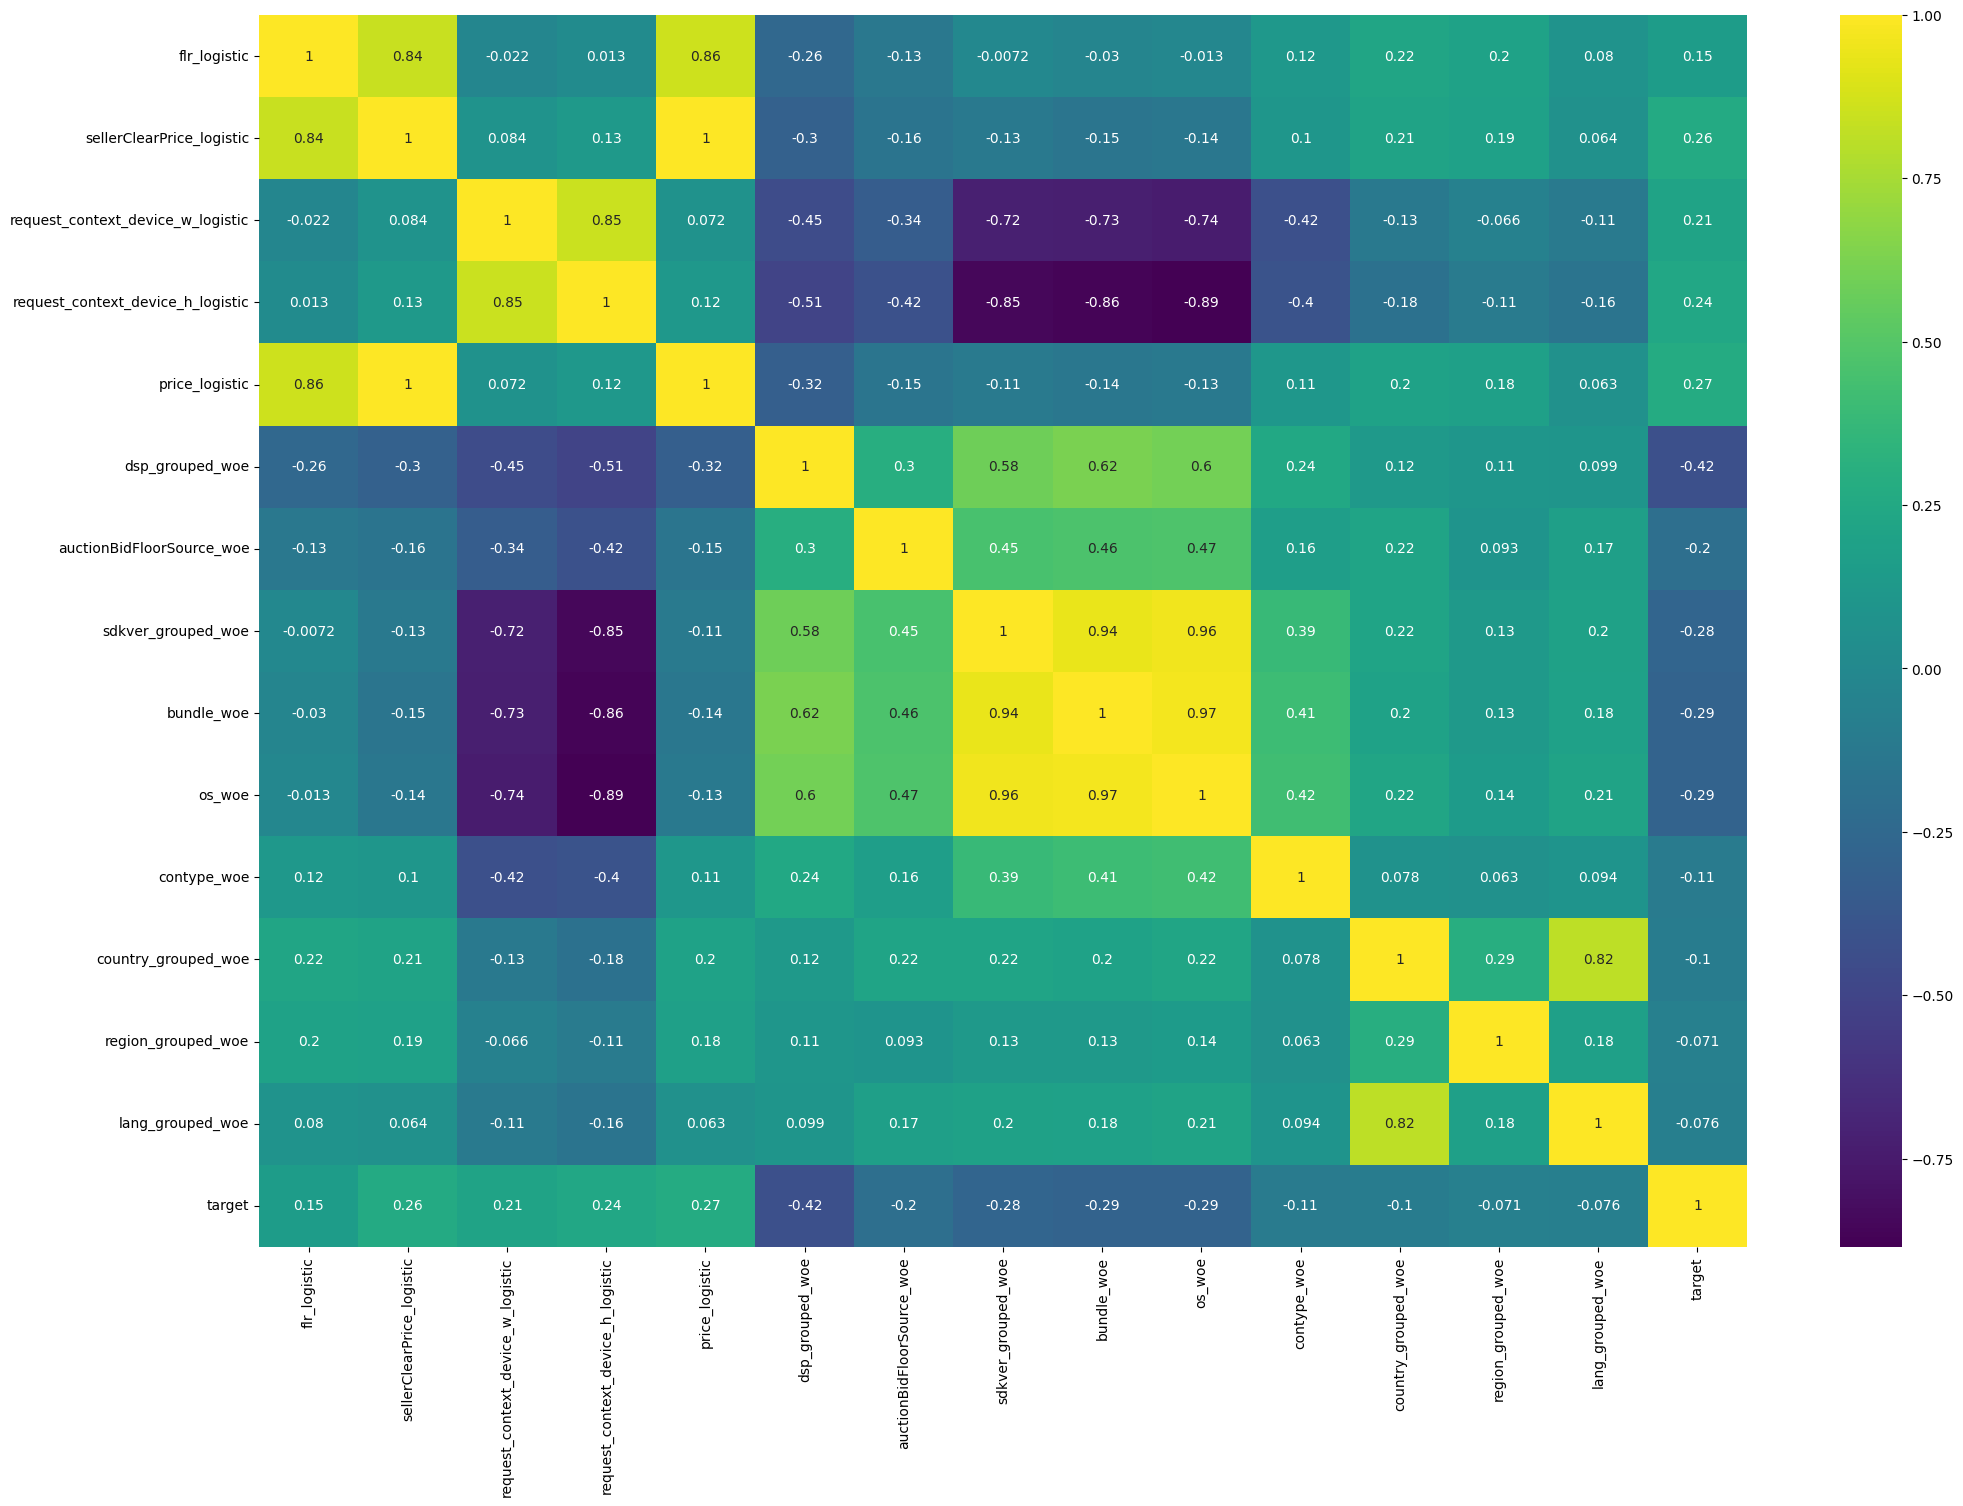

In [74]:
plt.figure(figsize=(24, 16))
sns.heatmap(data.corr(), annot=True, cmap='viridis')

****

****

# Outliers Detection and Removing

In [75]:
## We need to remove outliers found in the analysis

# 🔄 Data PreProcessing

**Section Goals:**
> - Remove or fill any missing data.
> - Remove unnecessary or repetitive features.
> - Convert categorical string features to dummy variables.

In [76]:
# The length of the data
print(f"The Length of the data: {data.shape}")

The Length of the data: (50000, 15)


In [77]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

### NA detection

In [78]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

In [79]:
#data.dropna(inplace=True)

## 🧮 Categorical Variables and Dummy Variables

In [80]:
print([column for column in data.columns if data[column].dtype == object])

['dsp_grouped_woe', 'auctionBidFloorSource_woe', 'sdkver_grouped_woe', 'bundle_woe', 'os_woe', 'contype_woe', 'country_grouped_woe', 'region_grouped_woe', 'lang_grouped_woe']


We can assess the necessity of dummy variables later if the WoE variables are not sufficient. For now, we will not introduce any dummy variables.

In [81]:
#dummies = ['']
#data = pd.get_dummies(data, columns=dummies, drop_first=True)

## 🔪 Train Test Split

In [82]:
w_p = data[target_feature].value_counts()[0] / data.shape[0]
w_n = data[target_feature].value_counts()[1] / data.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")

Weight of positive values 0.91578
Weight of negative values 0.08422


In [83]:
features_selected

['flr_logistic',
 'sellerClearPrice_logistic',
 'request_context_device_w_logistic',
 'request_context_device_h_logistic',
 'price_logistic',
 'dsp_grouped_woe',
 'auctionBidFloorSource_woe',
 'sdkver_grouped_woe',
 'bundle_woe',
 'os_woe',
 'contype_woe',
 'country_grouped_woe',
 'region_grouped_woe',
 'lang_grouped_woe']

In [84]:
features_selected_and_target = features_selected + [target_feature]

train = data
test = data_test
#train, test = train_test_split(data[features_selected_and_target], test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

(50000, 15)
(1500000, 15)


## 📏 Normalizing the data

We can, for example, apply Z-score normalization (standardization) or Min-Max normalization (scaling):

standardized_data = (data - data.mean()) / data.std()

normalized_data = (data - data.min()) / (data.max() - data.min())

However, for now, we will proceed with the raw data and evaluate the model performances.

In [85]:
X_train, y_train = train.drop(target_feature, axis=1), train[target_feature]
X_test, y_test = test.drop(target_feature, axis=1), test[target_feature]

# 🤖 Models Building

In [86]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)


#  ✔️ 1. Artificial Neural Networks (ANNs)

In [87]:

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [88]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [10, 10, 5]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model_ann = nn_model(
    num_columns=num_columns,
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model_ann.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 41ms/step - AUC: 0.6810 - loss: 0.4391 - val_AUC: 0.8658 - val_loss: 0.2524
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - AUC: 0.8704 - loss: 0.2106 - val_AUC: 0.8751 - val_loss: 0.2469
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 55ms/step - AUC: 0.8839 - loss: 0.2033 - val_AUC: 0.8784 - val_loss: 0.2457
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 123s 43ms/step - AUC: 0.8890 - loss: 0.1992 - val_AUC: 0.8811 - val_loss: 0.2443
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 100s 55ms/step - AUC: 0.8914 - loss: 0.1930 - val_AUC: 0.8829 - val_loss: 0.2412
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 55ms/step - AUC: 0.8915 - loss: 0.1941 - val_AUC: 0.8809 - val_loss: 0.2467
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - AUC: 0.8978 - loss: 0.1870 - val_AUC: 0.8861 - val_loss: 0.2394
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 55ms/step - AUC: 0.8981 - loss: 0.1941 - val_AUC: 0.8884 - val_loss: 0.2369
Epoch 9/20
1563/156

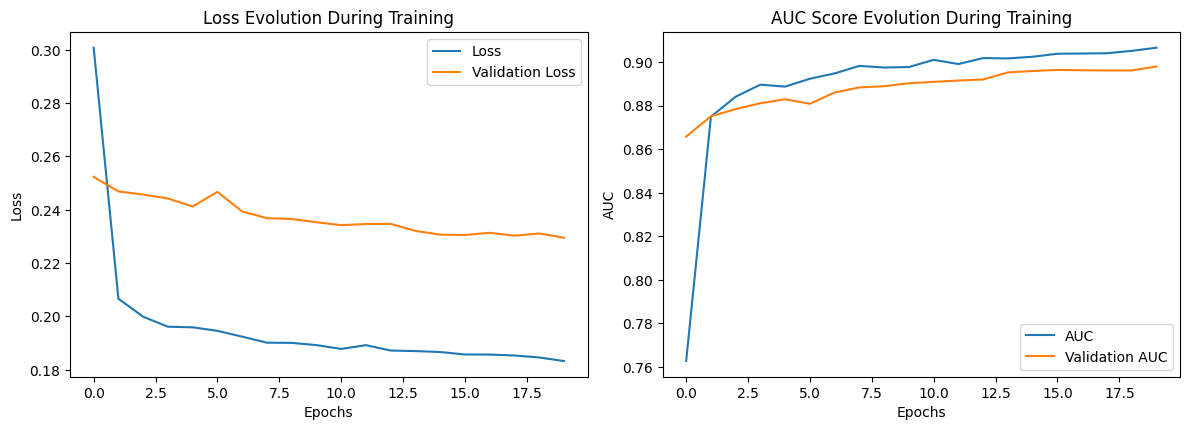

In [89]:
factor_utils.plot_learning_evolution(r)

In [90]:
# Step: Predict default probabilities on the training set
y_train_proba_pred_ann = model_ann.predict(X_train)
f1_ann, cutoff_ann, y_pred_train_ann = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_ann, verbose = True, text = "train")
y_test_proba_pred_ann = model_ann.predict(X_test)
f1_ann_test, _ , y_pred_test_ann= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_ann, cutoff_ann, verbose = True, text = "test")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
train
Optimal cutoff: [0.24714929]
Accuracy: 0.91878
F1 Score: 0.5604502651802143
46875/46875 ━━━━━━━━━━━━━━━━━━━━ 69s 1ms/step
test
Optimal cutoff: [0.24714929]
Accuracy: 0.8764753333333334
F1 Score: 0.5581071444754748


In [91]:
factor_utils.print_score(y_test, y_pred_test_ann.round(), train=False)

Test Result:
Accuracy Score: 87.65%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0       1.0  accuracy  macro avg  weighted avg
precision       0.96      0.47      0.88       0.71          0.90
recall          0.90      0.69      0.88       0.79          0.88
f1-score        0.93      0.56      0.88       0.74          0.89
support   1329268.00 170732.00      0.88 1500000.00    1500000.00
_______________________________________________
Confusion Matrix: 
 [[1197705  131563]
 [  53724  117008]]

 F1 score: 55.81%
 Gini: 58.67%



In [92]:
scores_Gini_dict = {
    'ANNs': {
        'Train': 2 * roc_auc_score(y_train, y_train_proba_pred_ann) - 1,
        'Test': 2 * roc_auc_score(y_test, y_test_proba_pred_ann) - 1,
    },
}

scores_F1_dict = {
    'ANNs': {
        'Train': f1_ann,
        'Test': f1_ann_test,
    },
}

In [ ]:
scores_Gini_dict

In [ ]:
scores_F1_dict

In [ ]:
# scores_Gini_dict = {
#     'ANNs': {
#         'Train': 0.8321704953480653,
#         'Test': 0.757568818691849,
#     },
# }

# scores_F1_dict = {
#     'ANNs': {
#         'Train': 0.22056323060573857,
#         'Test': 0.25956327063547785,
#     },
# }

# ✔️ 2. XGBoost Classifier

In [96]:
xgb_clf = XGBClassifier(use_label_encoder=False)

In [97]:
we_are_learning = True

if we_are_learning:
    param_grid = dict(
      n_estimators=stats.randint(10, 500),
      max_depth=stats.randint(1, 10),
      learning_rate=stats.uniform(0, 1))

    xgb_cv = RandomizedSearchCV(
      xgb_clf, param_grid, cv=3, n_iter=60,
      scoring='roc_auc', n_jobs=-1, verbose=1)

    xgb_cv.fit(X_train, y_train)
    best_params = xgb_cv.best_params_
else:
    best_params = {'learning_rate': 0.17219709930788796, 'max_depth': 3, 'n_estimators': 168}

print(f"Best Parameters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)


Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:21:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.18393843330886528, 'max_depth': 3, 'n_estimators': 281}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18393843330886528,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=281, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [98]:
y_train_proba_pred_xgb = xgb_clf.predict_proba(X_train)[:, 1]
f1_train_xgb, cutoff_xgb, y_pred_train_xgb = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_xgb, verbose = True, text = "train")
y_test_proba_pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]
f1_test_xgb, _ , y_pred_test_xgb= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_xgb, cutoff_xgb, verbose = True, text = "test")

train
Optimal cutoff: 0.36796215176582336
Accuracy: 0.93888
F1 Score: 0.6371408216575635
test
Optimal cutoff: 0.36796215176582336
Accuracy: 0.8967186666666667
F1 Score: 0.5879514867812118


In [99]:
factor_utils.print_score(y_train, y_pred_train_xgb, train = True)
factor_utils.print_score(y_test, y_pred_test_xgb, train=False)

Train Result:
Accuracy Score: 93.89%
_______________________________________________
CLASSIFICATION REPORT:
               0.0     1.0  accuracy  macro avg  weighted avg
precision     0.97    0.64      0.94       0.80          0.94
recall        0.97    0.64      0.94       0.80          0.94
f1-score      0.97    0.64      0.94       0.80          0.94
support   45789.00 4211.00      0.94   50000.00      50000.00
_______________________________________________
Confusion Matrix: 
 [[44261  1528]
 [ 1528  2683]]

 F1 score: 63.71%
 Gini: 59.58%

Test Result:
Accuracy Score: 89.67%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0       1.0  accuracy  macro avg  weighted avg
precision       0.95      0.54      0.90       0.75          0.91
recall          0.93      0.65      0.90       0.79          0.90
f1-score        0.94      0.59      0.90       0.76          0.90
support   1329268.00 170732.00      0.90 1500000.00    1500000.00
____________

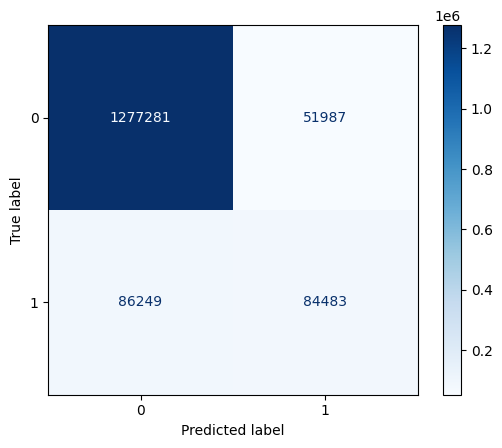

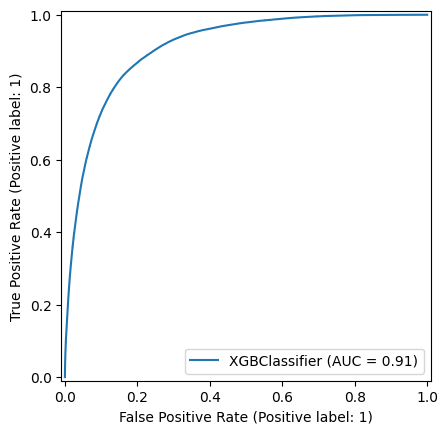

In [100]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_clf, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['0', '1']
)

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)

In [101]:
scores_Gini_dict['XGBoost'] = {
        'Train': 2 * roc_auc_score(y_train, y_pred_train_xgb) - 1,
        'Test': 2 * roc_auc_score(y_test, y_pred_test_xgb) - 1,
    }

scores_F1_dict['XGBoost'] = {
        'Train': f1_train_xgb,
        'Test': f1_test_xgb,
}


In [102]:
scores_Gini_dict

{'ANNs': {'Train': 0.8321704953480653, 'Test': 0.757568818691849},
 'XGBoost': {'Train': 0.6037703615033778, 'Test': 0.5761265219553064}}

In [103]:
scores_F1_dict

{'ANNs': {'Train': 0.22056323060573857, 'Test': 0.25956327063547785},
 'XGBoost': {'Train': 0.6371408216575635, 'Test': 0.5879514867812118}}

In [104]:
 # scores_Gini_dict['XGBoost'] = {
 #         'Train': 0.5350935940120811,
 #         'Test': 0.5263625343587082,
 #     }

  #scores_F1_dict['XGBoost'] = {
  #        'Train': 0.5736994219653179,
  #        'Test': 0.5459496040012266,
  #}

# ✔️ 3. Random Forest Classifier

In [105]:
we_are_learning = True

if we_are_learning:
    param_grid = dict(
     n_estimators=stats.randint(100, 1500),
     max_depth=stats.randint(10, 100),  #max_depth (максимальная глубина деревьев).
     min_samples_split=stats.randint(1, 10), #min_samples_split (минимальное количество примеров для разбиения узла).
     min_samples_leaf=stats.randint(1, 10), #min_samples_leaf (минимальное количество примеров в листе).
     #max_features (ограничить число признаков для разбиения).
    )

    rf_clf = RandomForestClassifier(n_estimators=10)
    rf_cv = RandomizedSearchCV(
        rf_clf, param_grid, cv=3, n_iter=60,
        scoring='roc_auc', n_jobs=-1, verbose=1
    )
    rf_cv.fit(X_train, y_train)
    best_params = rf_cv.best_params_
else:
    best_params = dict(
    n_estimators=563,
    max_depth=13,  #max_depth (максимальная глубина деревьев).
    min_samples_split=8, #min_samples_split (минимальное количество примеров для разбиения узла).
    min_samples_leaf=8, #min_samples_leaf (минимальное количество примеров в листе).
    #max_features (ограничить число признаков для разбиения).
    )

print(f"Best Parameters: {best_params}")
rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
21 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1350}


RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=1350)

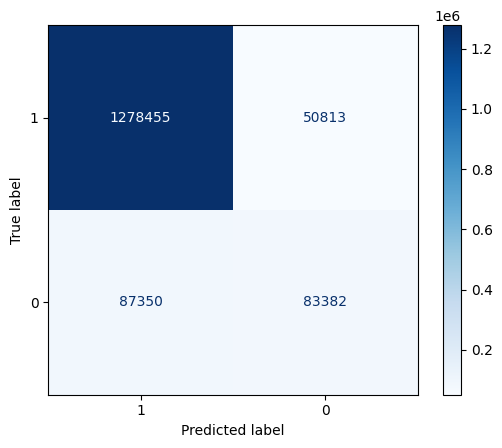

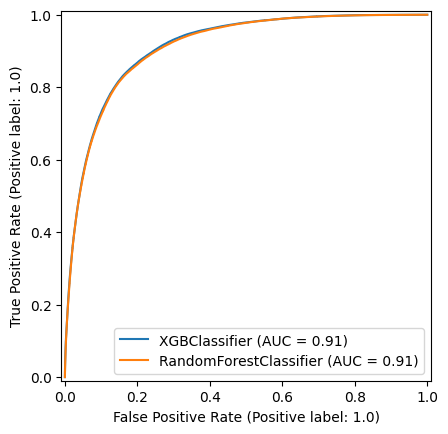

In [106]:
disp = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test,
                             cmap='Blues', values_format='d',
                             display_labels=['1', '0'])

disp = RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)

In [107]:
# Step: Predict default probabilities on the training set
y_train_proba_pred_rf = rf_clf.predict_proba(X_train)[:, 1]
f1_train_rf, cutoff_rf, y_pred_train_rf = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_rf, verbose = True, text = "train")
y_test_proba_pred_rf = rf_clf.predict_proba(X_test)[:, 1]
f1_test_rf, _ , y_pred_test_rf= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_rf, cutoff_rf, verbose = True, text = "test")

train
Optimal cutoff: 0.36577710466186636
Accuracy: 0.94872
F1 Score: 0.6955592495844217
test
Optimal cutoff: 0.36577710466186636
Accuracy: 0.895768
F1 Score: 0.5851693835965359


In [108]:
factor_utils.print_score(y_train, y_pred_train_rf, train=True)
factor_utils.print_score(y_test, y_pred_test_rf, train=False)

Train Result:
Accuracy Score: 94.87%
_______________________________________________
CLASSIFICATION REPORT:
               0.0     1.0  accuracy  macro avg  weighted avg
precision     0.97    0.70      0.95       0.83          0.95
recall        0.97    0.70      0.95       0.83          0.95
f1-score      0.97    0.70      0.95       0.83          0.95
support   45789.00 4211.00      0.95   50000.00      50000.00
_______________________________________________
Confusion Matrix: 
 [[44507  1282]
 [ 1282  2929]]

 F1 score: 69.56%
 Gini: 66.12%

Test Result:
Accuracy Score: 89.58%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0       1.0  accuracy  macro avg  weighted avg
precision       0.95      0.53      0.90       0.74          0.91
recall          0.93      0.65      0.90       0.79          0.90
f1-score        0.94      0.59      0.90       0.76          0.90
support   1329268.00 170732.00      0.90 1500000.00    1500000.00
____________

In [109]:
scores_Gini_dict['Random Forest'] = {
        'Train': 2 * roc_auc_score(y_train, y_pred_train_rf) - 1,
        'Test': 2 * roc_auc_score(y_test, y_pred_test_rf) - 1,
    }

scores_F1_dict['Random Forest'] = {
        'Train': f1_train_rf,
        'Test': f1_test_rf,
}

In [110]:
scores_Gini_dict


{'ANNs': {'Train': 0.8321704953480653, 'Test': 0.757568818691849},
 'XGBoost': {'Train': 0.6037703615033778, 'Test': 0.5761265219553064},
 'Random Forest': {'Train': 0.667561258800609, 'Test': 0.5737520171133548}}

In [111]:

scores_F1_dict

{'ANNs': {'Train': 0.22056323060573857, 'Test': 0.25956327063547785},
 'XGBoost': {'Train': 0.6371408216575635, 'Test': 0.5879514867812118},
 'Random Forest': {'Train': 0.6955592495844217, 'Test': 0.5851693835965359}}

# ✔️ 4. Logistic regression

In [112]:
# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [113]:
# Step: Predict default probabilities on the training set
y_train_proba_pred_logreg = logreg.predict_proba(X_train)[:, 1]
f1_train_logreg, cutoff_logreg, y_pred_train_logreg = factor_utils.make_optimal_cutoff_get_f1(y_train, y_train_proba_pred_logreg, verbose = True, text = "train")
y_test_proba_pred_logreg = logreg.predict_proba(X_test)[:, 1]
f1_test_logreg, _ , y_pred_test_logreg= factor_utils.make_optimal_cutoff_get_f1(y_test, y_test_proba_pred_logreg, cutoff_logreg, verbose = True, text = "test")

train
Optimal cutoff: 0.35171916460185365
Accuracy: 0.92004
F1 Score: 0.525290904773213
test
Optimal cutoff: 0.35171916460185365
Accuracy: 0.87988
F1 Score: 0.5294971693580397


In [114]:
factor_utils.print_score(y_train, y_pred_train_logreg, train=True)
factor_utils.print_score(y_test, y_pred_test_logreg, train=False)

Train Result:
Accuracy Score: 92.00%
_______________________________________________
CLASSIFICATION REPORT:
               0.0     1.0  accuracy  macro avg  weighted avg
precision     0.96    0.53      0.92       0.74          0.92
recall        0.96    0.53      0.92       0.74          0.92
f1-score      0.96    0.53      0.92       0.74          0.92
support   45789.00 4211.00      0.92   50000.00      50000.00
_______________________________________________
Confusion Matrix: 
 [[43790  1999]
 [ 1999  2212]]

 F1 score: 52.53%
 Gini: 47.80%

Test Result:
Accuracy Score: 87.99%
_______________________________________________
CLASSIFICATION REPORT:
                 0.0       1.0  accuracy  macro avg  weighted avg
precision       0.95      0.48      0.88       0.71          0.89
recall          0.92      0.59      0.88       0.76          0.88
f1-score        0.93      0.53      0.88       0.73          0.89
support   1329268.00 170732.00      0.88 1500000.00    1500000.00
____________

In [115]:
scores_Gini_dict['Logistic regression'] = {
        'Train': 2 * roc_auc_score(y_train, y_pred_train_logreg) - 1,
        'Test': 2 * roc_auc_score(y_test, y_pred_test_logreg) - 1,
    }
scores_Gini_dict

{'ANNs': {'Train': 0.8321704953480653, 'Test': 0.757568818691849},
 'XGBoost': {'Train': 0.6037703615033778, 'Test': 0.5761265219553064},
 'Random Forest': {'Train': 0.667561258800609, 'Test': 0.5737520171133548},
 'Logistic regression': {'Train': 0.481634131312338,
  'Test': 0.5104515429369698}}

In [116]:
scores_F1_dict['Logistic regression'] = {
        'Train': f1_train_logreg,
        'Test': f1_test_logreg,
}
scores_F1_dict

{'ANNs': {'Train': 0.22056323060573857, 'Test': 0.25956327063547785},
 'XGBoost': {'Train': 0.6371408216575635, 'Test': 0.5879514867812118},
 'Random Forest': {'Train': 0.6955592495844217, 'Test': 0.5851693835965359},
 'Logistic regression': {'Train': 0.525290904773213,
  'Test': 0.5294971693580397}}

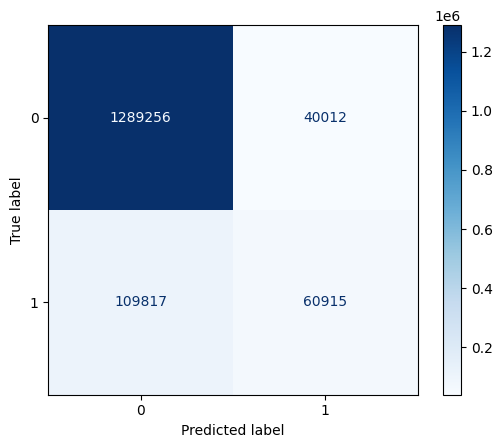

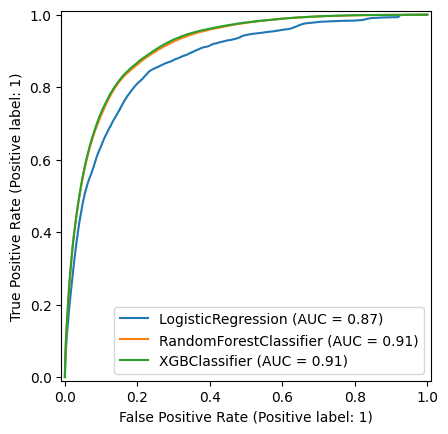

In [117]:
disp = ConfusionMatrixDisplay.from_estimator(
    logreg, X_test, y_test,
    cmap='Blues', values_format='d',
    display_labels=['0', '1']
)

disp = RocCurveDisplay.from_estimator(logreg, X_test, y_test)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, ax=disp.ax_)
RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test, ax=disp.ax_)


# 📊 Comparing Models Prerformance

In [118]:
#ml_models = {
#    'Random Forest': rf_clf,
#    'XGBoost': xgb_clf,
#    'ANNs': model_ann,
#    'Logreg': logreg,
#}

#for model2 in ml_models:
#    print(f"{model2.upper():{30}} roc_auc_score: {roc_auc_score(y_test, ml_models[model2].predict(X_test)):.3f}")

In [119]:
scores_F1_dict

{'ANNs': {'Train': 0.22056323060573857, 'Test': 0.25956327063547785},
 'XGBoost': {'Train': 0.6371408216575635, 'Test': 0.5879514867812118},
 'Random Forest': {'Train': 0.6955592495844217, 'Test': 0.5851693835965359},
 'Logistic regression': {'Train': 0.525290904773213,
  'Test': 0.5294971693580397}}

In [120]:
scores_F1_df = pd.DataFrame(scores_F1_dict)
barh_plot_F1 = scores_F1_df.hvplot.barh(
    width=500, height=400,
    title="F1 of ML Models", xlabel="F1 Scores",
    alpha=0.4, legend='top'
)

baseline_F1  = 0.503
Hline = hv.HLine(baseline_F1).opts(color='red', line_width=2)
# Совмещение графиков
barh_with_Hline_F1 = barh_plot_F1 * Hline
barh_with_Hline_F1

:Overlay
   .Bars.I  :Bars   [index,Variable]   (value)
   .HLine.I :HLine   [x,y]

In [121]:
scores_Gini_dict

{'ANNs': {'Train': 0.8321704953480653, 'Test': 0.757568818691849},
 'XGBoost': {'Train': 0.6037703615033778, 'Test': 0.5761265219553064},
 'Random Forest': {'Train': 0.667561258800609, 'Test': 0.5737520171133548},
 'Logistic regression': {'Train': 0.481634131312338,
  'Test': 0.5104515429369698}}

In [122]:
scores_df = pd.DataFrame(scores_Gini_dict)
barh_plot_Gini = scores_df.hvplot.barh(
    width=500, height=400,
    title="Gini Scores of ML Models", xlabel="ROC Scores",
    alpha=0.4, legend='top'
)

baseline_ROC_AUC  = 0.667
baseline_Gini = 2 * baseline_ROC_AUC - 1
Hline_Gini = hv.HLine(baseline_Gini).opts(color='red', line_width=2)
# Совмещение графиков
barh_with_Hline_Gini = barh_plot_Gini * Hline_Gini
barh_with_Hline_Gini

:Overlay
   .Bars.I  :Bars   [index,Variable]   (value)
   .HLine.I :HLine   [x,y]